In [1]:
import itertools
import sys, os

import numpy as np
import pandas as pd
from scipy.special import comb
from scipy import stats
import scipy.cluster.hierarchy as hac
from scipy.optimize import curve_fit

import matplotlib.pyplot as plt
plt.style.use('classic')
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm

sns.set(rc={'figure.figsize':(15,8)})
sns.set_context('paper')

In [2]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_log_error

In [3]:
from statsmodels.tools.eval_measures import rmse

In [4]:
%load_ext autoreload
%autoreload 2
import CCPA_lib as cp


In [5]:
sns.set_context('talk')
sns.set_style('white')

In [6]:
plt.rcParams["figure.dpi"] = 300

In [7]:
ppallete = 'RdYlGn'#'YlGn_d' #"BuGn_d"
porder = ['MED4',  'MIT9312','MIT0604', 'Natl2A', 'MIT9313']
ppallete = [ '#62A586', '#face6e','#f79934', '#7A9BC8', '#F47681', ]
psizes = [150,120,200,120,350]
pmarkers = ['o', 's', '^', 'D', '*']

# #ffd7a1
    
pedge = 'green'
apallete = "spring"
aorder = ['DE', 'DE1', '1A3', 'ATCC', 'BS11']
amarkers = ['P', 'X', 'h', '<','>']
apallete = ['#6dad36', '#c7e89f', '#f5c4e1', '#d5579d', '#8a0850']

aedge='orange'
epallete = ['#6cf0ba', '#d13f75', '#eeb7cb', '#b9d2d8', '#407f90']
#sns.diverging_palette(355, 217, s=74, l=50, n=4) #'Paired' # 'BrBG'# "coolwarm"
eorder = ['e1','e3', 'e4', 'e5', 'e6']
#aedge='orange'

espallete = ['#6cf0ba', '#D55282', '#538B9B']

In [8]:
PRO_COLOR = 'MediumSeaGreen'
ALT_COLOR = 'Gold'

In [9]:
dflist=list()
for i in os.listdir('fcmfiles'):
    if i.endswith('.csv'):
        d = pd.read_csv(os.path.join('fcmfiles', i))
        n = os.path.splitext(i)[0]
        _, experiment, day = n.split('_')
        d['experiment'] = experiment
        d['day'] = day.replace('Days','')
        dflist.append(d)
df = pd.concat(dflist)
df.loc[df.PRO == 'C9B', 'PRO'] = 'MIT0604'

In [10]:
df.head()

,PRO,ALT,sample,PRO.1,ALT.1,experiment,day
0,MED4,1A3,1A,7.485642e+06,2.992351e+07,exp1,100
1,MED4,1A3,1B,6.720907e+06,2.159764e+07,exp1,100
2,MED4,1A3,1C,1.121335e+07,1.742056e+07,exp1,100
3,MIT9313,1A3,2A,1.415617e+06,5.134250e+06,exp1,100
4,MIT9313,1A3,2B,1.018640e+06,4.885134e+06,exp1,100


In [11]:
df.isna().sum()

PRO           45
ALT           45
sample         0
PRO.1         36
ALT.1         73
experiment     0
day            0
dtype: int64

In [12]:
df = df.dropna(subset=['PRO.1', 'ALT.1'], how='all')

In [13]:
df['day'] = pd.to_numeric(df['day'])

In [14]:
for c in df.columns:
    if c in ['PRO.1', 'ALT.1']:
        continue
    print(c, df[c].unique())

PRO ['MED4' 'MIT9313' 'MIT9312' 'Natl2A' 'MIT0604' nan]
ALT ['1A3' 'DE' 'DE1' 'BS11' 'ATCC' nan]
sample ['1A' '1B' '1C' '2A' '2B' '2C' '3A' '3B' '3C' '4A' '4B' '4C' '5A' '5B'
 '5C' '6A' '6B' '6C' '7A' '7B' '7C' '8A' '8B' '8C' '9A' '9B' '9C' '10A'
 '10B' '10C' '11A' '11B' '11C' '12A' '12B' '12C' '13A' '13B' '13C' '14A'
 '14B' '14C' '15A' '15B' '15C' '16A' '16B' '16C' '17A' '17B' '17C' '18A'
 '18B' '18C' '19A' '19B' '19C' '20A' '20B' '20C' '21A' '21B' '21C' '22A'
 '22B' '22C' '23A' '23B' '23C' '24A' '24B' '24C' '25C' '26A' '26B' '26C'
 '27A' '27B' '27C' '28A' '28B' '28C' '29A' '29B' '29C' '30A' '30B' '30C'
 '31A' '31B' '31C' '32A' '32B' '32C' '33A' '33B' '33C' '34A' '34B' '35A'
 '35B' '34C' '35C' '25A' '25B']
experiment ['exp1' 'exp3' 'exp4']
day [100 140  60]


In [15]:
df.dtypes

PRO            object
ALT            object
sample         object
PRO.1         float64
ALT.1         float64
experiment     object
day             int64
dtype: object

In [16]:
df.loc[df['PRO'].isna() & df.experiment.isin(['exp1']) & df.day.isin([140]), 'PRO.1'] = np.NaN



In [17]:
df = df.loc[df['sample'] != '26C']

In [18]:
df = df.loc[df['experiment'] == 'exp1']

In [19]:
df.isna().sum()

PRO           43
ALT           42
sample         0
PRO.1         43
ALT.1         60
experiment     0
day            0
dtype: int64

In [20]:
# cell quotas (fg/cell)

PRO_N_min = 3.5
PRO_N_max = 10
PRO_C_min = 17
PRO_C_max = 50



ALT_N_min = 13
ALT_N_max = 25
ALT_C_min = 56
ALT_C_max = 88

MW_C = 12
MW_N = 14



In [21]:
# The values for the C and N quotas vary quite widely between studies (e.g. see Table S1 in the SI of Dalit’s paper, attached) but in general:
# MED4 and MIT9312 are about the same
# NATL is about 1.5x larger
# MIT9313 is about 2x larger
# Alteromonas is about 3x larger than MED4

base_pro_N = 7
PRO_N_QUOTA = {
    'MED4' : base_pro_N, 
    'MIT9312' : base_pro_N,
    'MIT0604' : base_pro_N,
    'Natl2A' : base_pro_N * 1.5,    
     'MIT9313' : base_pro_N * 2,
}

ALT_N_quota = base_pro_N * 3


In [22]:
porder

['MED4', 'MIT9312', 'MIT0604', 'Natl2A', 'MIT9313']

In [23]:
df['culture'] = 'Co_Culture'
df.loc[df['PRO'].isna(), 'culture'] = 'ALT Only'
df.loc[df['ALT'].isna(), 'culture'] = 'PRO Only'


In [24]:
df['pair'] = df['PRO'] + ',' + df['ALT']
df.loc[df['PRO'].isna(), 'pair'] = df.loc[df['PRO'].isna(),'ALT']
df.loc[df['ALT'].isna(), 'pair'] = df.loc[df['ALT'].isna(),'PRO']


In [25]:
df.head()

,PRO,ALT,sample,PRO.1,ALT.1,experiment,day,culture,pair
0,MED4,1A3,1A,7.485642e+06,2.992351e+07,exp1,100,Co_Culture,"MED4,1A3"
1,MED4,1A3,1B,6.720907e+06,2.159764e+07,exp1,100,Co_Culture,"MED4,1A3"
2,MED4,1A3,1C,1.121335e+07,1.742056e+07,exp1,100,Co_Culture,"MED4,1A3"
3,MIT9313,1A3,2A,1.415617e+06,5.134250e+06,exp1,100,Co_Culture,"MIT9313,1A3"
4,MIT9313,1A3,2B,1.018640e+06,4.885134e+06,exp1,100,Co_Culture,"MIT9313,1A3"


In [26]:
# fg to umol
# mass  (g) = conc (mol/L) X volume (L) x MW (g/mol)

# cell/ml x fg/cell = fg/ml
# fg/ml * 1e9 / mw(g/mol)  = umol/ml 


In [27]:
# 100 nmol / L = 

# umol / L   * 1e3 (umol->nmol)=  nmol / l
DN = 100 + 20 

In [28]:
initial_N_min = PRO_N_min * 1e6 * 1e-6 / MW_N +  ALT_N_min * 1e7* 1e-6 / MW_N + DN
initial_N_max = PRO_N_max * 1e6 * 1e-6 / MW_N +  ALT_N_max * 1e7* 1e-6 / MW_N + DN
initial_N_min, initial_N_max

(129.53571428571428, 138.57142857142858)

In [29]:
PRO_N_min * 1e6 * 1e-6 / MW_N , PRO_N_max * 1e6 * 1e-6 / MW_N , ALT_N_min * 1e7* 1e-6 / MW_N ,  ALT_N_max * 1e7* 1e-6 / MW_N 


(0.25, 0.7142857142857143, 9.285714285714286, 17.857142857142858)

In [30]:
initial_C_min = PRO_C_min * 1e6 * 1e-6 / MW_C +  ALT_C_min * 1e7* 1e-6 / MW_C + 120
initial_C_max = PRO_C_max * 1e6 * 1e-6 / MW_C +  ALT_C_max * 1e7* 1e-6 / MW_C + 120
initial_C_min, initial_C_max

(168.08333333333331, 197.5)

In [31]:
PRO_C_min * 1e6 * 1e-6 / MW_C , PRO_C_max * 1e6 * 1e-6 / MW_C , ALT_C_min * 1e7* 1e-6 / MW_C ,  ALT_C_max * 1e7* 1e-6 / MW_C


(1.4166666666666667, 4.166666666666667, 46.666666666666664, 73.33333333333333)

In [32]:

# umol / l

# umol/l        = cells/ml    * fg/cell   *  femto-> micro  / ml->L/ g/mol
# umol/l        = cells/ml    * fg/cell   *  1e-9  / 1e-3  / g/mol

df['C[PRO] min'] = df['PRO.1'] * PRO_C_min * 1e-6 / MW_C
df['C[PRO] max'] = df['PRO.1'] * PRO_C_max * 1e-6 / MW_C
df['N[PRO] min'] = df['PRO.1'] * PRO_N_min * 1e-6 / MW_N
df['N[PRO] max'] = df['PRO.1'] * PRO_N_max * 1e-6 / MW_N

df['C[ALT] min'] = df['ALT.1'] * ALT_C_min * 1e-6 / MW_C
df['C[ALT] max'] = df['ALT.1'] * ALT_C_max * 1e-6 / MW_C
df['N[ALT] min'] = df['ALT.1'] * ALT_N_min * 1e-6 / MW_N
df['N[ALT] max'] = df['ALT.1'] * ALT_N_max * 1e-6 / MW_N


In [33]:
df['C[Total] min'] = df['C[ALT] min'] + df['C[PRO] min']
df['C[Total] max'] = df['C[ALT] max'] + df['C[PRO] max']
df['N[Total] min'] = df['N[ALT] min'] + df['N[PRO] min']
df['N[Total] max'] = df['N[ALT] max'] + df['N[PRO] max']

df.loc[df['culture'].isin(['ALT Only']), 'C[Total] min'] = df.loc[df['culture'].isin(['ALT Only']), 'C[ALT] min']
df.loc[df['culture'].isin(['ALT Only']), 'C[Total] max'] = df.loc[df['culture'].isin(['ALT Only']), 'C[ALT] max']
df.loc[df['culture'].isin(['ALT Only']), 'N[Total] min'] = df.loc[df['culture'].isin(['ALT Only']), 'N[ALT] min']
df.loc[df['culture'].isin(['ALT Only']), 'N[Total] max'] = df.loc[df['culture'].isin(['ALT Only']), 'N[ALT] max']

df.loc[df['culture'].isin(['PRO Only']), 'C[Total] min'] = df.loc[df['culture'].isin(['PRO Only']), 'C[PRO] min']
df.loc[df['culture'].isin(['PRO Only']), 'C[Total] max'] = df.loc[df['culture'].isin(['PRO Only']), 'C[PRO] max']
df.loc[df['culture'].isin(['PRO Only']), 'N[Total] min'] = df.loc[df['culture'].isin(['PRO Only']), 'N[PRO] min']
df.loc[df['culture'].isin(['PRO Only']), 'N[Total] max'] = df.loc[df['culture'].isin(['PRO Only']), 'N[PRO] max']


In [98]:
df['percent_N'] = df['N[Total] min'] / initial_N_max

C:\Users\wosnat\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='N[Total] min', ylabel='Density'>

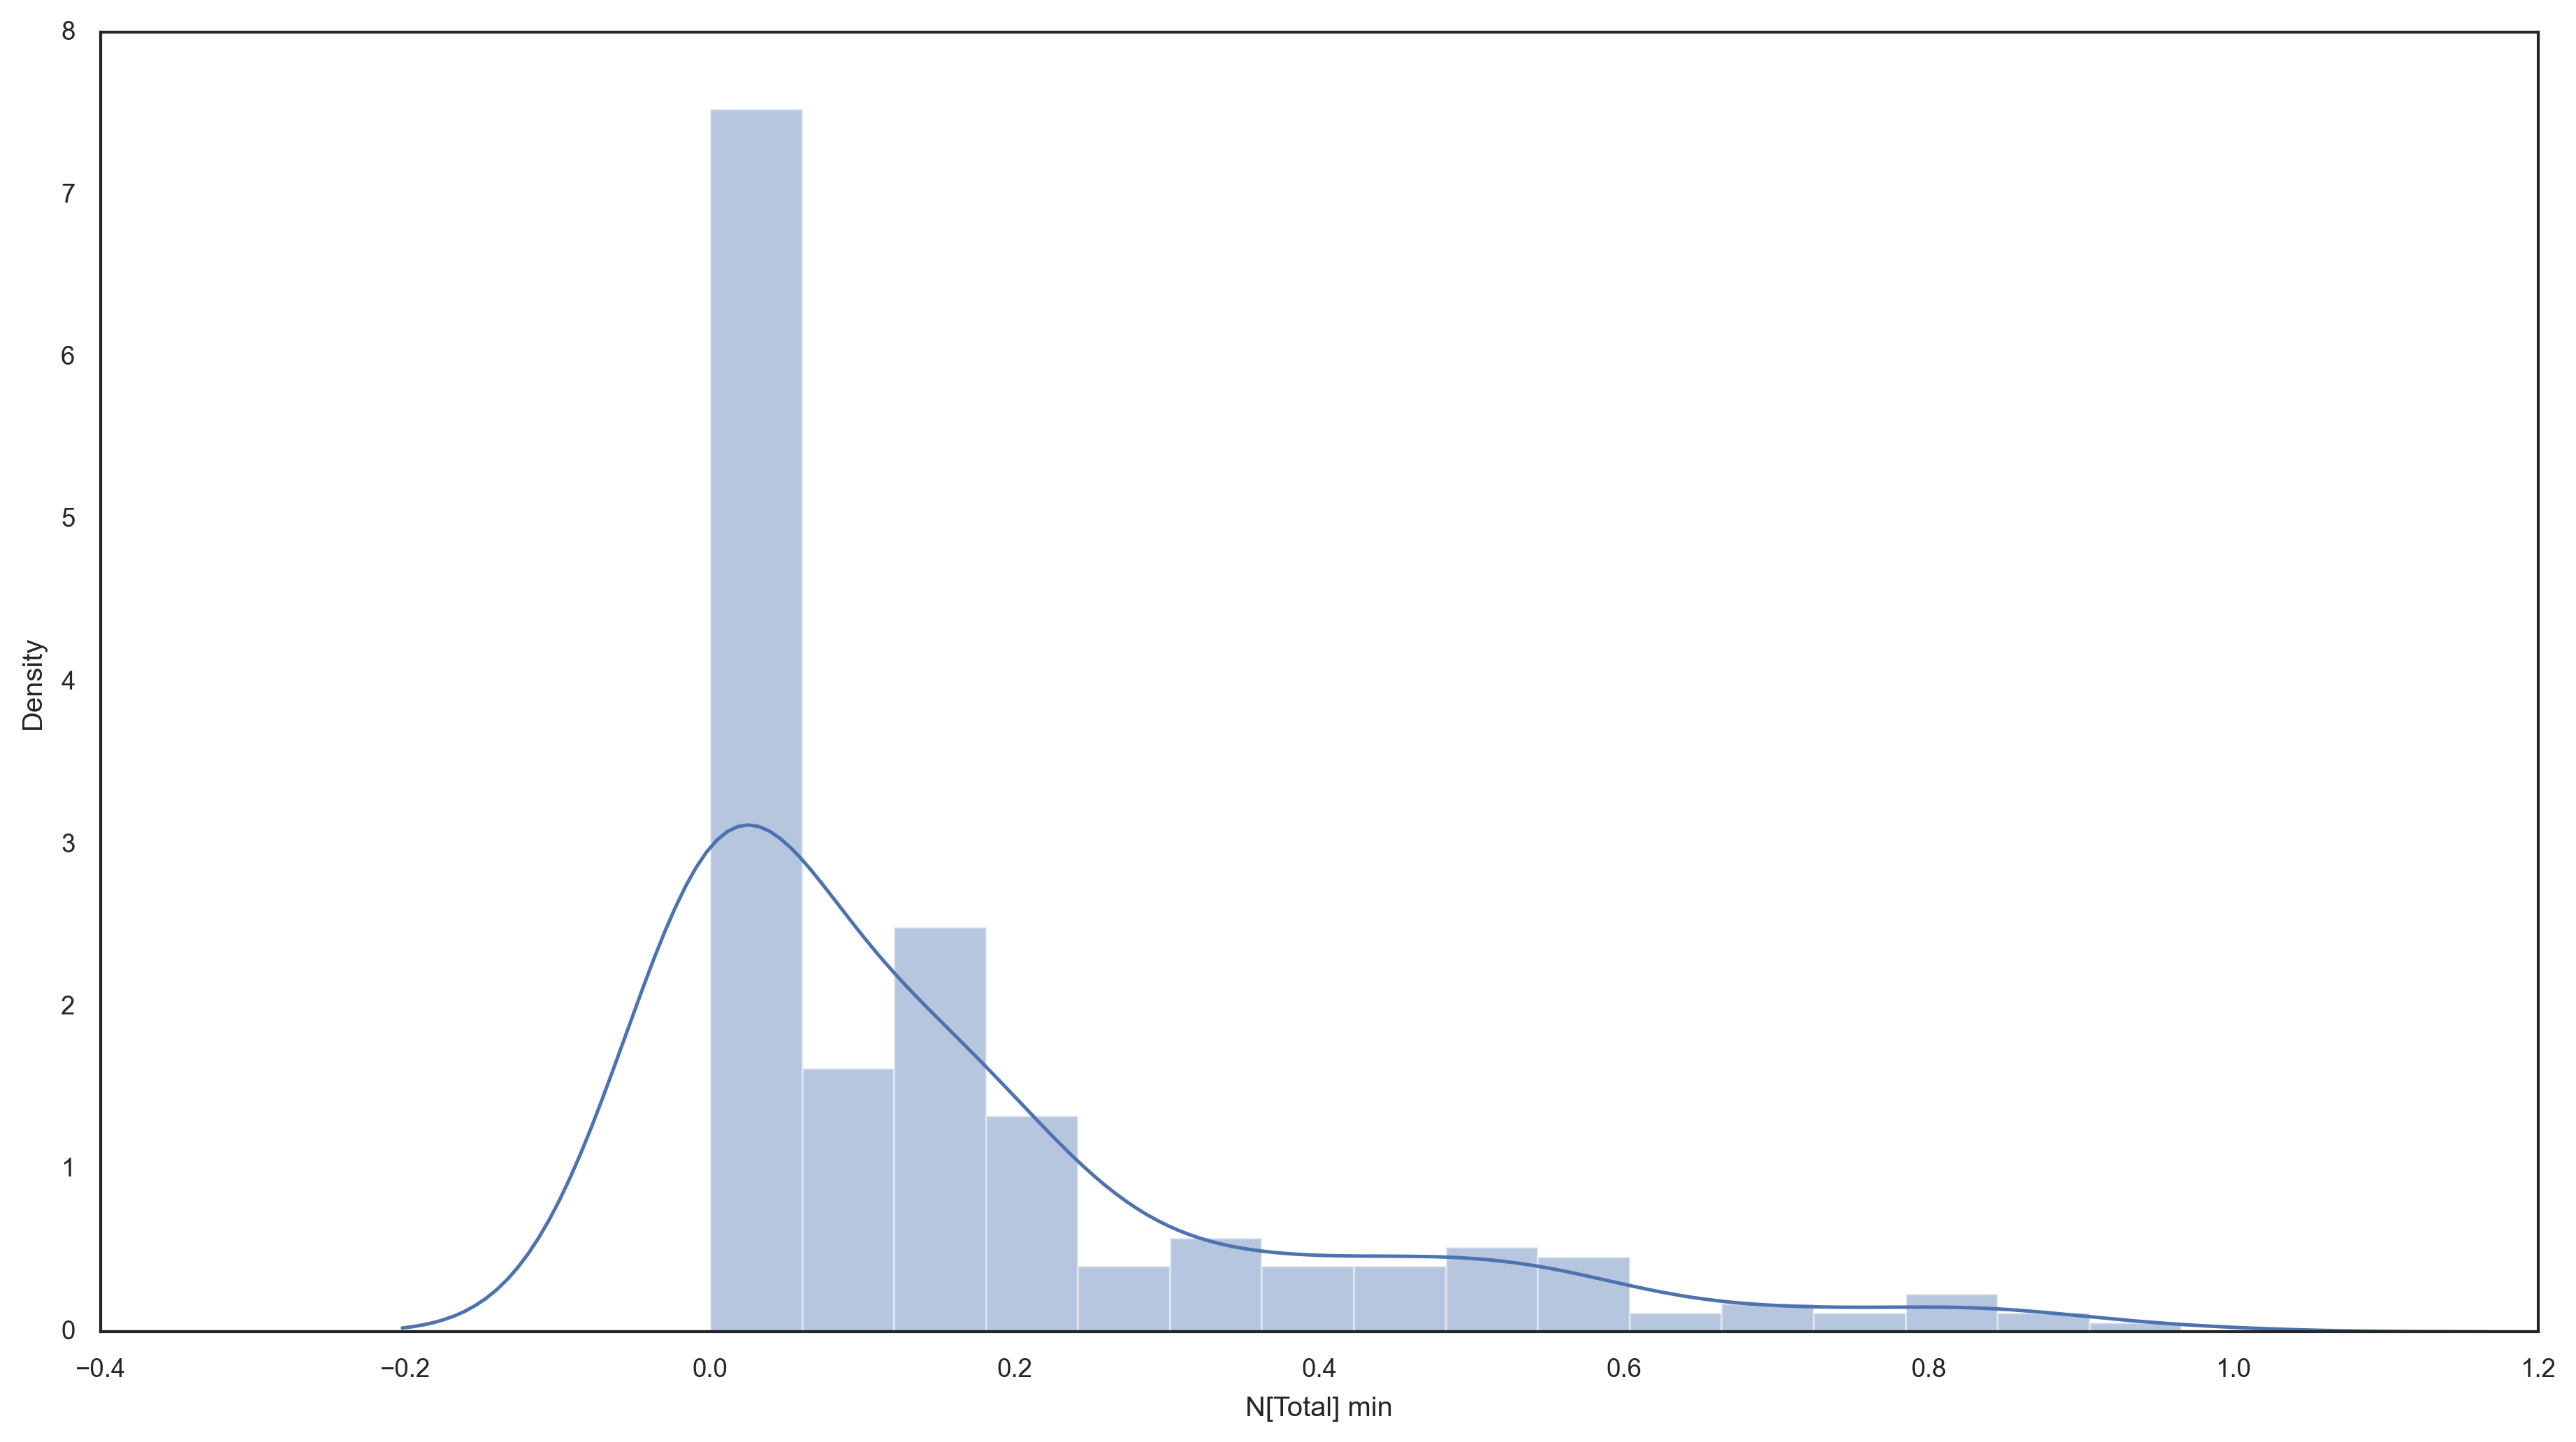

In [103]:
 sns.distplot(df['N[Total] min'] / initial_N_max)

In [34]:
df.head()

,PRO,ALT,sample,PRO.1,ALT.1,experiment,day,culture,pair,C[PRO] min,...,N[PRO] min,N[PRO] max,C[ALT] min,C[ALT] max,N[ALT] min,N[ALT] max,C[Total] min,C[Total] max,N[Total] min,N[Total] max
0,MED4,1A3,1A,7.485642e+06,2.992351e+07,exp1,100,Co_Culture,"MED4,1A3",10.604660,...,1.871411,5.346887,139.643047,219.439074,27.786117,53.434840,150.247707,250.629251,29.657527,58.781727
1,MED4,1A3,1B,6.720907e+06,2.159764e+07,exp1,100,Co_Culture,"MED4,1A3",9.521285,...,1.680227,4.800648,100.788998,158.382711,20.054954,38.567219,110.310283,186.386490,21.735180,43.367866
2,MED4,1A3,1C,1.121335e+07,1.742056e+07,exp1,100,Co_Culture,"MED4,1A3",15.885579,...,2.803338,8.009536,81.295962,127.750797,16.176237,31.108149,97.181541,174.473089,18.979575,39.117684
3,MIT9313,1A3,2A,1.415617e+06,5.134250e+06,exp1,100,Co_Culture,"MIT9313,1A3",2.005458,...,0.353904,1.011155,23.959834,37.651168,4.767518,9.168304,25.965292,43.549573,5.121422,10.179459
4,MIT9313,1A3,2B,1.018640e+06,4.885134e+06,exp1,100,Co_Culture,"MIT9313,1A3",1.443073,...,0.254660,0.727600,22.797293,35.824318,4.536196,8.723454,24.240366,40.068650,4.790856,9.451054


In [35]:
c_cols = ['C[PRO] min', 'C[PRO] max',  'C[ALT] min', 'C[ALT] max','C[Total] min', 'C[Total] max']
n_cols = ['N[PRO] min', 'N[PRO] max',  'N[ALT] min', 'N[ALT] max','N[Total] min', 'N[Total] max']


In [36]:
df.groupby(['culture', 'day']).agg(['mean', 'std'])[c_cols]

C[PRO] min             C[PRO] max             C[ALT] min  \
                     mean        std        mean        std        mean   
culture    day                                                            
ALT Only   60         NaN        NaN         NaN        NaN  160.778047   
           100        NaN        NaN         NaN        NaN   19.749787   
           140        NaN        NaN         NaN        NaN         NaN   
Co_Culture 60   34.181303  20.208286  100.533243  59.436134  270.070310   
           100  13.906934   9.371140   40.902748  27.562176   88.325220   
           140   1.142252   2.057747    3.359564   6.052196    4.221406   
PRO Only   60    0.037205   0.013480    0.109427   0.039647         NaN   
           100   0.191135   0.705210    0.562161   2.074146         NaN   
           140   0.000583   0.000544    0.001714   0.001599         NaN   

                            C[ALT] max             C[Total] min              \
                       std        mean         std         mean         std   
culture    day                                                                
ALT Only   60   112.866086  252.651217  177.360992   160.778047  112.866086   
           100   20.032645   31.035380   31.479870    19.749787   20.032645   
           140         NaN         NaN         NaN          NaN         NaN   
Co_Culture 60   145.318370  424.396201  228.357439   304.178816  155.813675   
           100   38.797468  138.796774   60.967450   102.232154   44.945800   
           140    3.294574    6.633638    5.177188     5.350950    4.147840   
PRO Only   60          NaN         NaN         NaN     0.037205    0.013480   
           100         NaN         NaN         NaN     0.191135    0.705210   
           140         NaN         NaN         NaN     0.000583    0.000544   

               C[Total] max              
                       mean         std  
culture    day                           
ALT Only   60    252.651217  177.360992  
           100    31.035380   31.479870  
           140          NaN         NaN  
Co_Culture 60    524.715338  261.614328  
           100   179.699522   80.315159  
           140     9.955828    8.567640  
PRO Only   60      0.109427    0.039647  
           100     0.562161    2.074146  
           140     0.001714    0.001599

In [37]:
n_cols


['N[PRO] min',
 'N[PRO] max',
 'N[ALT] min',
 'N[ALT] max',
 'N[Total] min',
 'N[Total] max']

In [38]:
df.groupby(['culture', 'day']).agg(['mean', 'std'])[['N[Total] min',
 'N[Total] max']]

N[Total] min            N[Total] max           
                       mean        std         mean        std
culture    day                                                
ALT Only   60     31.991550  22.458048    61.522212  43.188553
           100     3.929805   3.986087     7.557317   7.665553
           140          NaN        NaN          NaN        NaN
Co_Culture 60     59.757628  30.747564   120.540797  61.053439
           100    20.029081   8.793615    40.809815  18.031169
           140     1.039305   0.797325     2.184852   1.754120
PRO Only   60      0.006566   0.002379     0.018759   0.006797
           100     0.033730   0.124449     0.096371   0.355568
           140     0.000103   0.000096     0.000294   0.000274

In [107]:
df.groupby(['culture', 'day'])['percent_N'].describe()

count          mean           std           min           25%  \
culture    day                                                                  
ALT Only   60    15.0  2.308669e-01  1.620684e-01  1.598755e-03  1.246716e-01   
           100   13.0  2.835941e-02  2.876558e-02  3.899727e-06  7.068255e-03   
           140    0.0           NaN           NaN           NaN           NaN   
Co_Culture 60    71.0  4.312406e-01  2.218896e-01  8.405260e-02  2.261257e-01   
           100   73.0  1.445398e-01  6.345908e-02  3.011837e-02  1.071268e-01   
           140   72.0  7.500139e-03  5.753894e-03  3.850301e-06  2.290743e-03   
PRO Only   60    14.0  4.738072e-05  1.716662e-05  9.649964e-06  3.608247e-05   
           100   14.0  2.434101e-04  8.980840e-04  1.282552e-06  2.671984e-06   
           140   14.0  7.422680e-07  6.922852e-07  1.804124e-07  3.337629e-07   

                         50%       75%       max  
culture    day                                    
ALT Only   60   1.585890e-01  0.364385  0.562687  
           100  2.052036e-02  0.035096  0.091800  
           140           NaN       NaN       NaN  
Co_Culture 60   4.279209e-01  0.564723  0.965973  
           100  1.333356e-01  0.176898  0.335148  
           140  6.230422e-03  0.011730  0.020597  
PRO Only   60   5.244546e-05  0.000060  0.000070  
           100  3.633898e-06  0.000004  0.003364  
           140  4.149485e-07  0.000001  0.000003

In [139]:
df.groupby(['culture', 'day', 'PRO']).agg(['mean', 'std'])['percent_N']

mean           std
culture    day PRO                                 
ALT Only   60  ALT Only  2.308669e-01  1.620684e-01
           100 ALT Only  2.835941e-02  2.876558e-02
           140 ALT Only           NaN           NaN
Co_Culture 60  MED4      6.488435e-01  1.510532e-01
               MIT0604   5.481273e-01  1.134469e-01
               MIT9312   2.060295e-01  7.369870e-02
               MIT9313   2.473611e-01  8.922203e-02
               Natl2A    5.437259e-01  1.956917e-01
           100 MED4      2.194487e-01  5.933677e-02
               MIT0604   1.686485e-01  4.241209e-02
               MIT9312   1.127159e-01  1.322357e-02
               MIT9313   6.826481e-02  2.251294e-02
               Natl2A    1.568354e-01  3.055850e-02
           140 MED4      6.308078e-03  3.825266e-03
               MIT0604   1.375986e-02  3.992312e-03
               MIT9312   2.296242e-03  9.390510e-04
               MIT9313   6.117176e-03  5.901429e-03
               Natl2A    1.027128e-02  5.534988e-03
PRO Only   60  MED4      2.964916e-05  4.678339e-06
               MIT0604   5.412371e-05  1.305376e-05
               MIT9312   5.803964e-05  5.394834e-06
               MIT9313   6.195557e-05  7.367296e-06
               Natl2A    3.538320e-05  2.242737e-05
           100 MED4      1.852576e-06  4.936546e-07
               MIT0604   3.847657e-06  6.046010e-07
               MIT9312   3.705151e-06  6.530437e-07
               MIT9313   3.847657e-06  1.131105e-06
               Natl2A    1.123943e-03  1.939693e-03
           140 MED4      1.443299e-06  1.256686e-06
               MIT0604   6.855670e-07  4.592549e-07
               MIT9312   3.006873e-07  1.102338e-07
               MIT9313   3.006873e-07  8.332890e-08
               Natl2A    9.621993e-07  1.159889e-07

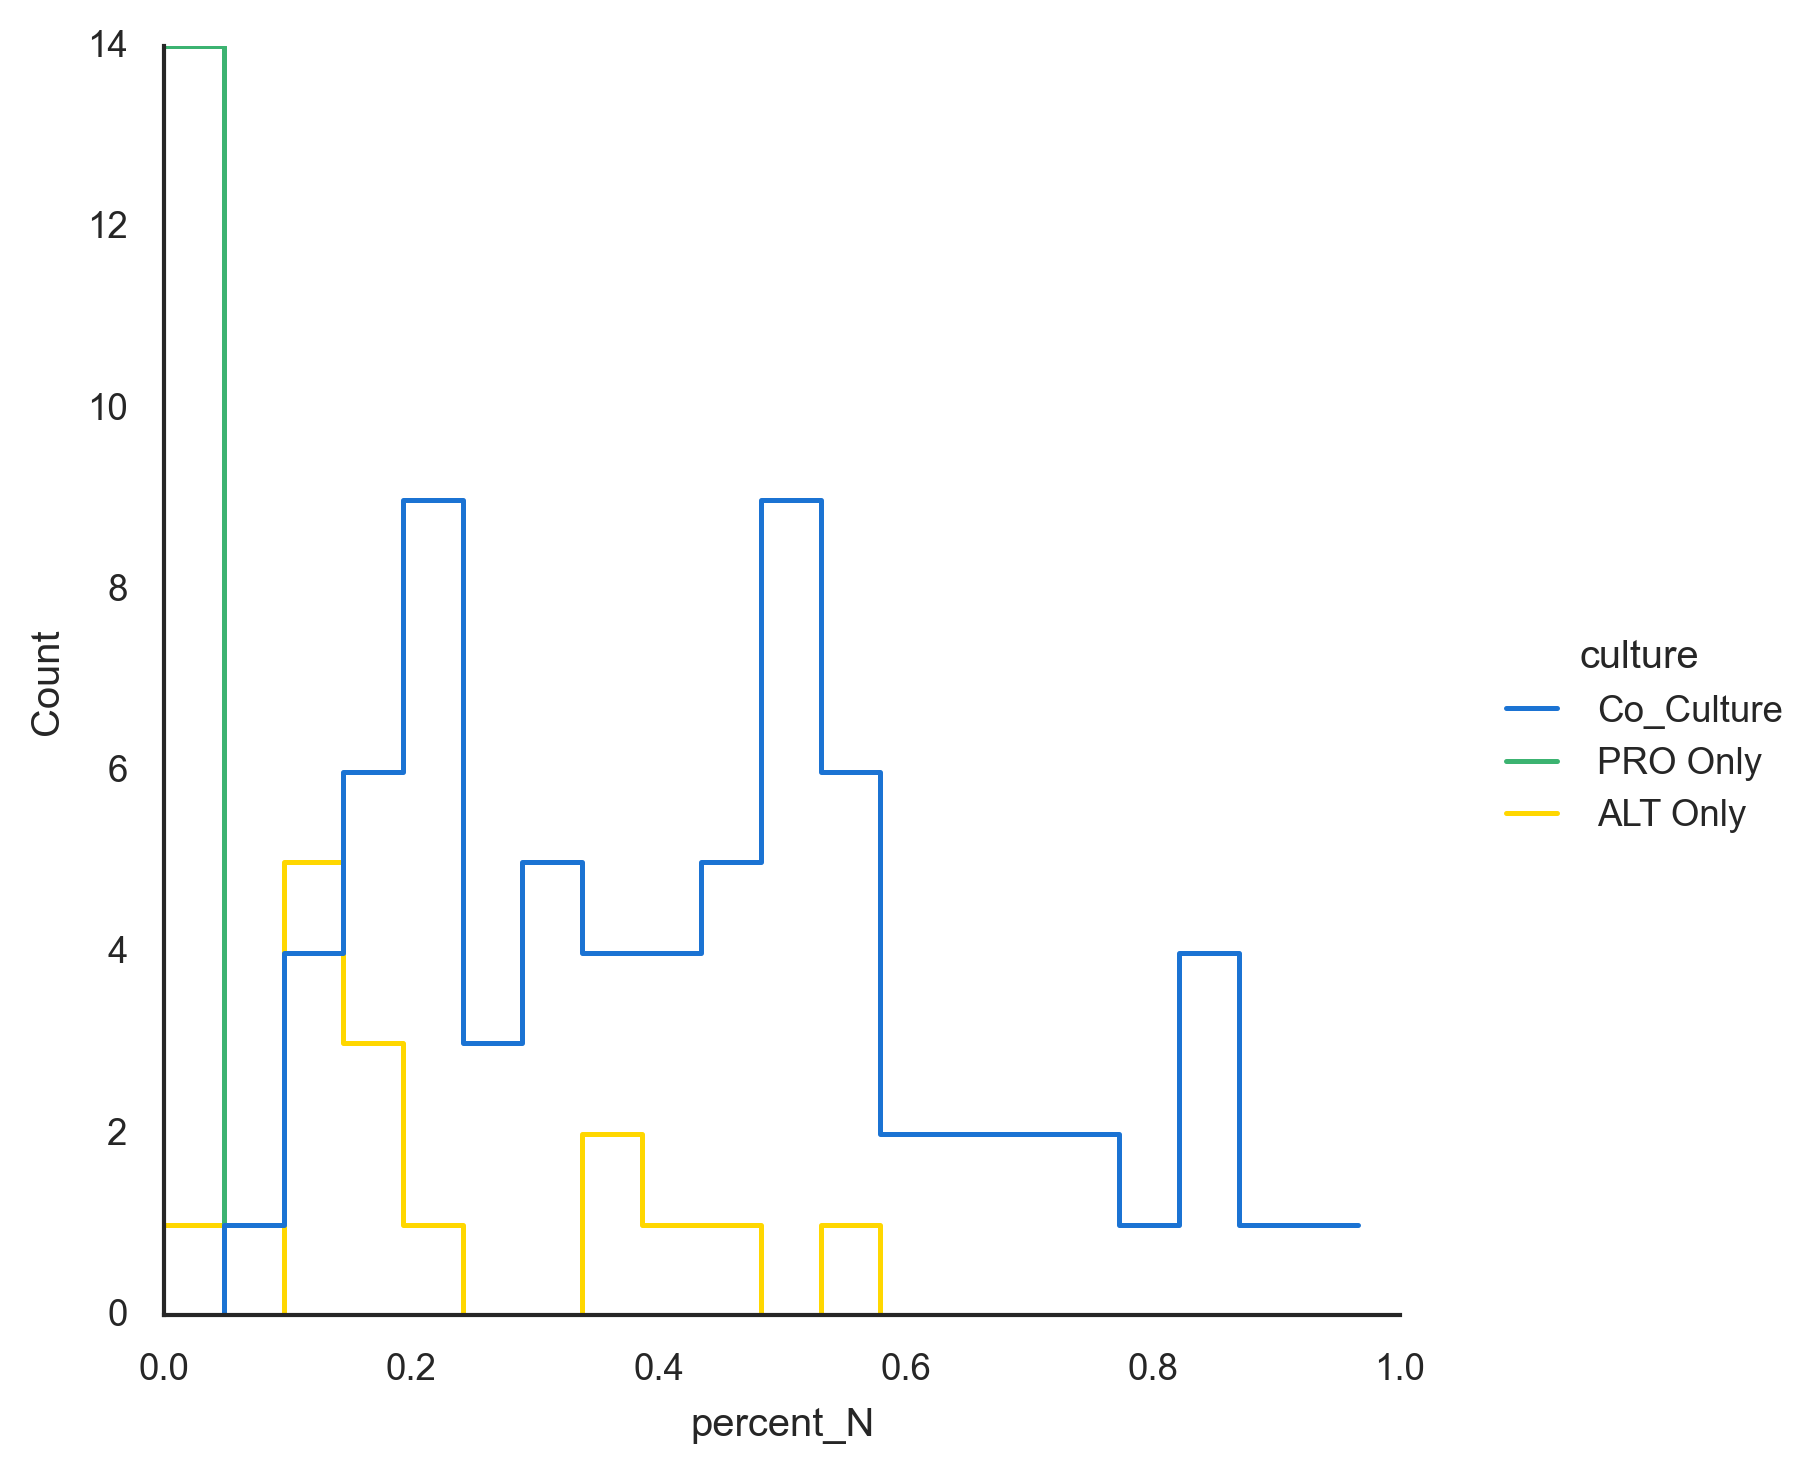

In [117]:
sns.displot(data = df.loc[df.day == 60],
            hue='culture', x='percent_N',  element="step", bins=20,
                       palette=['#1B73D3', PRO_COLOR, ALT_COLOR, ], 
            hue_order=['Co_Culture', 'PRO Only', 'ALT Only', ],
            fill=False,
)

In [39]:
df.groupby(['culture', 'day']).agg(['mean', 'std'])[['N[ALT] min',
 'N[ALT] max']]

N[ALT] min             N[ALT] max           
                     mean        std        mean        std
culture    day                                             
ALT Only   60   31.991550  22.458048   61.522212  43.188553
           100   3.929805   3.986087    7.557317   7.665553
           140        NaN        NaN         NaN        NaN
Co_Culture 60   53.738480  28.915390  103.343231  55.606519
           100  17.574916   7.719904   33.797916  14.845970
           140   0.839974   0.655553    1.615334   1.260679
PRO Only   60         NaN        NaN         NaN        NaN
           100        NaN        NaN         NaN        NaN
           140        NaN        NaN         NaN        NaN

In [40]:
df.groupby(['culture', 'day']).agg(['mean', 'std'])[['N[PRO] min',
 'N[PRO] max']]

N[PRO] min           N[PRO] max           
                     mean       std       mean        std
culture    day                                           
ALT Only   60         NaN       NaN        NaN        NaN
           100        NaN       NaN        NaN        NaN
           140        NaN       NaN        NaN        NaN
Co_Culture 60    6.031995  3.566168  17.234270  10.189052
           100   2.454165  1.653731   7.011900   4.724944
           140   0.201574  0.363132   0.575925   1.037519
PRO Only   60    0.006566  0.002379   0.018759   0.006797
           100   0.033730  0.124449   0.096371   0.355568
           140   0.000103  0.000096   0.000294   0.000274

In [41]:
df.groupby(['culture', 'day']).agg(['mean', 'std', 'count'])[['C[Total] min',
 'C[Total] max']]

C[Total] min                   C[Total] max                  
                       mean         std count         mean         std count
culture    day                                                              
ALT Only   60    160.778047  112.866086    15   252.651217  177.360992    15
           100    19.749787   20.032645    13    31.035380   31.479870    13
           140          NaN         NaN     0          NaN         NaN     0
Co_Culture 60    304.178816  155.813675    71   524.715338  261.614328    71
           100   102.232154   44.945800    73   179.699522   80.315159    73
           140     5.350950    4.147840    72     9.955828    8.567640    72
PRO Only   60      0.037205    0.013480    14     0.109427    0.039647    14
           100     0.191135    0.705210    14     0.562161    2.074146    14
           140     0.000583    0.000544    14     0.001714    0.001599    14

In [42]:
df.loc[df['culture'].isin(['Co_Culture']) & (df.day == 140)]['experiment'].value_counts()

exp1    73
Name: experiment, dtype: int64

In [43]:
df.groupby(['culture', 'day']).agg(['mean', 'std'])[['C[ALT] min',
 'C[ALT] max']]

C[ALT] min              C[ALT] max            
                      mean         std        mean         std
culture    day                                                
ALT Only   60   160.778047  112.866086  252.651217  177.360992
           100   19.749787   20.032645   31.035380   31.479870
           140         NaN         NaN         NaN         NaN
Co_Culture 60   270.070310  145.318370  424.396201  228.357439
           100   88.325220   38.797468  138.796774   60.967450
           140    4.221406    3.294574    6.633638    5.177188
PRO Only   60          NaN         NaN         NaN         NaN
           100         NaN         NaN         NaN         NaN
           140         NaN         NaN         NaN         NaN

In [44]:
df.groupby(['culture', 'day']).agg(['mean', 'std', 'count'])[['C[PRO] min',
 'C[PRO] max']]

C[PRO] min                   C[PRO] max                 
                     mean        std count        mean        std count
culture    day                                                         
ALT Only   60         NaN        NaN     0         NaN        NaN     0
           100        NaN        NaN     0         NaN        NaN     0
           140        NaN        NaN     0         NaN        NaN     0
Co_Culture 60   34.181303  20.208286    73  100.533243  59.436134    73
           100  13.906934   9.371140    73   40.902748  27.562176    73
           140   1.142252   2.057747    73    3.359564   6.052196    73
PRO Only   60    0.037205   0.013480    14    0.109427   0.039647    14
           100   0.191135   0.705210    14    0.562161   2.074146    14
           140   0.000583   0.000544    14    0.001714   0.001599    14

In [45]:
df.groupby(['culture', 'day']).agg(['mean', 'std'])[['PRO.1',
 'ALT.1']]

PRO.1                       ALT.1              
                        mean           std          mean           std
culture    day                                                        
ALT Only   60            NaN           NaN  3.445244e+07  2.418559e+07
           100           NaN           NaN  4.232097e+06  4.292710e+06
           140           NaN           NaN           NaN           NaN
Co_Culture 60   2.412798e+07  1.426467e+07  5.787221e+07  3.113965e+07
           100  9.816660e+06  6.614922e+06  1.892683e+07  8.313743e+06
           140  8.062954e+05  1.452527e+06  9.045870e+05  7.059802e+05
PRO Only   60   2.626246e+04  9.515213e+03           NaN           NaN
           100  1.349188e+05  4.977951e+05           NaN           NaN
           140  4.114286e+02  3.837238e+02           NaN           NaN

In [46]:
mdf = df.loc[df.experiment.isin(['exp1'])].melt(
    id_vars=['PRO', 'ALT', 'sample', 'day', 'culture', 'experiment', 'pair']
    
)

In [47]:
df.columns

Index(['PRO', 'ALT', 'sample', 'PRO.1', 'ALT.1', 'experiment', 'day',
       'culture', 'pair', 'C[PRO] min', 'C[PRO] max', 'N[PRO] min',
       'N[PRO] max', 'C[ALT] min', 'C[ALT] max', 'N[ALT] min', 'N[ALT] max',
       'C[Total] min', 'C[Total] max', 'N[Total] min', 'N[Total] max'],
      dtype='object')

In [50]:
df = df.fillna({'PRO': 'Axenic', 'ALT': 'Axenic'})


In [51]:
df.loc[df.PRO.isin(['Axenic']), 'PRO'] = 'ALT Only'
df.loc[df.ALT.isin(['Axenic']), 'ALT'] = 'PRO Only'


In [52]:
mdf.loc[mdf.PRO.isna(), 'PRO'] = 'ALT Only'
mdf.loc[mdf.ALT.isna(), 'ALT'] = 'PRO Only'


In [53]:
c_cols

['C[PRO] min',
 'C[PRO] max',
 'C[ALT] min',
 'C[ALT] max',
 'C[Total] min',
 'C[Total] max']

In [55]:
mdf.loc[mdf.variable.isin(['C[PRO] min', 'C[PRO] max','N[PRO] min', 'N[PRO] max',]), 'biomass of'] = 'PRO'
mdf.loc[mdf.variable.isin(['C[ALT] min', 'C[ALT] max','N[ALT] min', 'N[ALT] max',]), 'biomass of'] = 'ALT'
mdf.loc[mdf.variable.isin(['C[Total] min', 'C[Total] max','N[Total] min', 'N[Total] max',]), 'biomass of'] = 'Total'

In [56]:
mdf.loc[mdf['biomass of'].isin(['PRO']) & mdf.culture.isin(['PRO Only']), 'biomass of'] = 'PRO Only'
mdf.loc[mdf['biomass of'].isin(['ALT']) & mdf.culture.isin(['ALT Only']), 'biomass of'] = 'ALT Only'


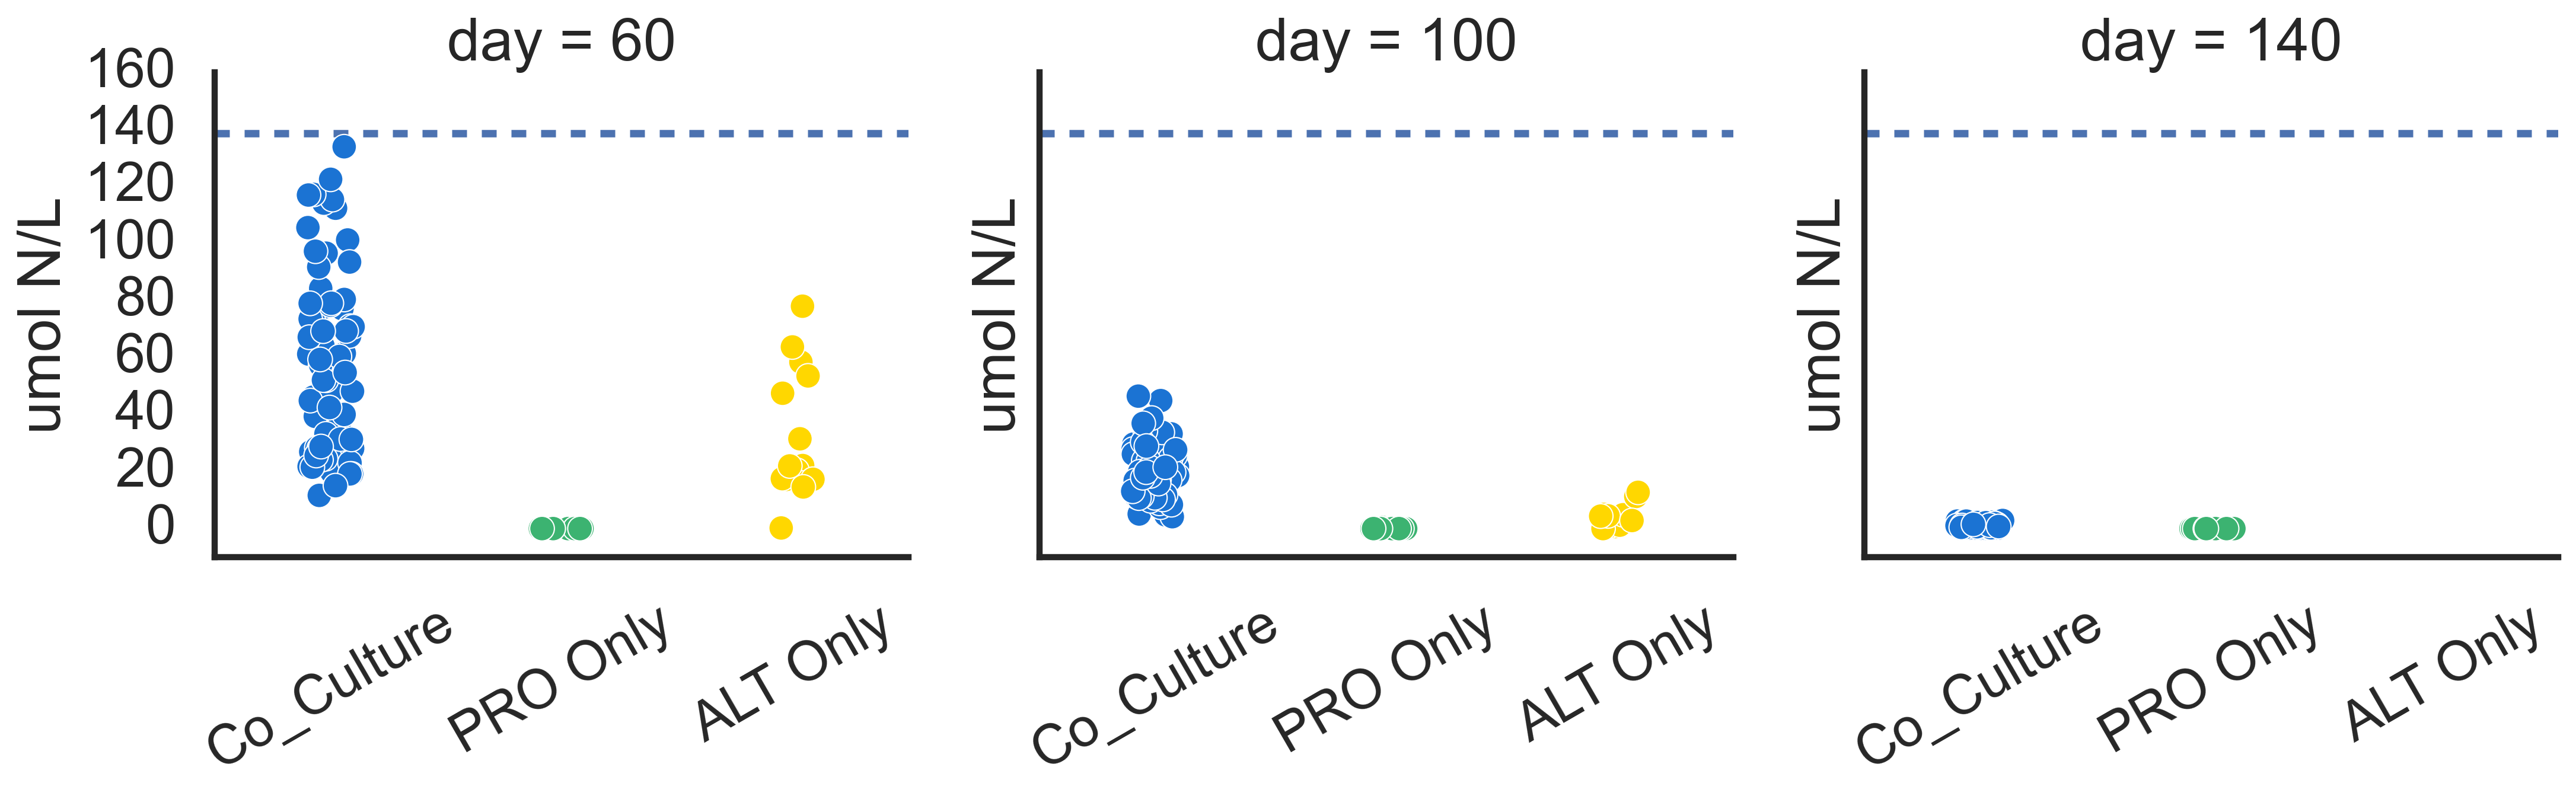

In [122]:

sns.set_context('poster')
g = sns.catplot(data=mdf.loc[mdf.variable.isin(['N[Total] min', #'N[Total] max'
                                               ])],
            hue='culture', y='value', #hue='culture', 
            col='day',x='culture',
            #kind='box', 
            #kind='box',
            #order=porder + ['ALT Only'],
            palette=['#1B73D3', PRO_COLOR, ALT_COLOR, ], hue_order=['Co_Culture', 'PRO Only', 'ALT Only', ],
            order=['Co_Culture', 'PRO Only', 'ALT Only', ],
            #hue_order=porder + ['ALT Only'],
            #palette=ppallete + ['grey'], 
            dodge=False,
                edgecolor='white', linewidth=0.5,
            #sharey=False, #
                s=10, 
           ).set(ylabel='umol N/L', xlabel='', 
                 ylim=(-10, 160)
                 #yscale='log'
                ).set_xticklabels(rotation=30) 

plt.tight_layout()
for ax in g.axes.flat:
    ax.axhline(initial_N_max, ls='--')

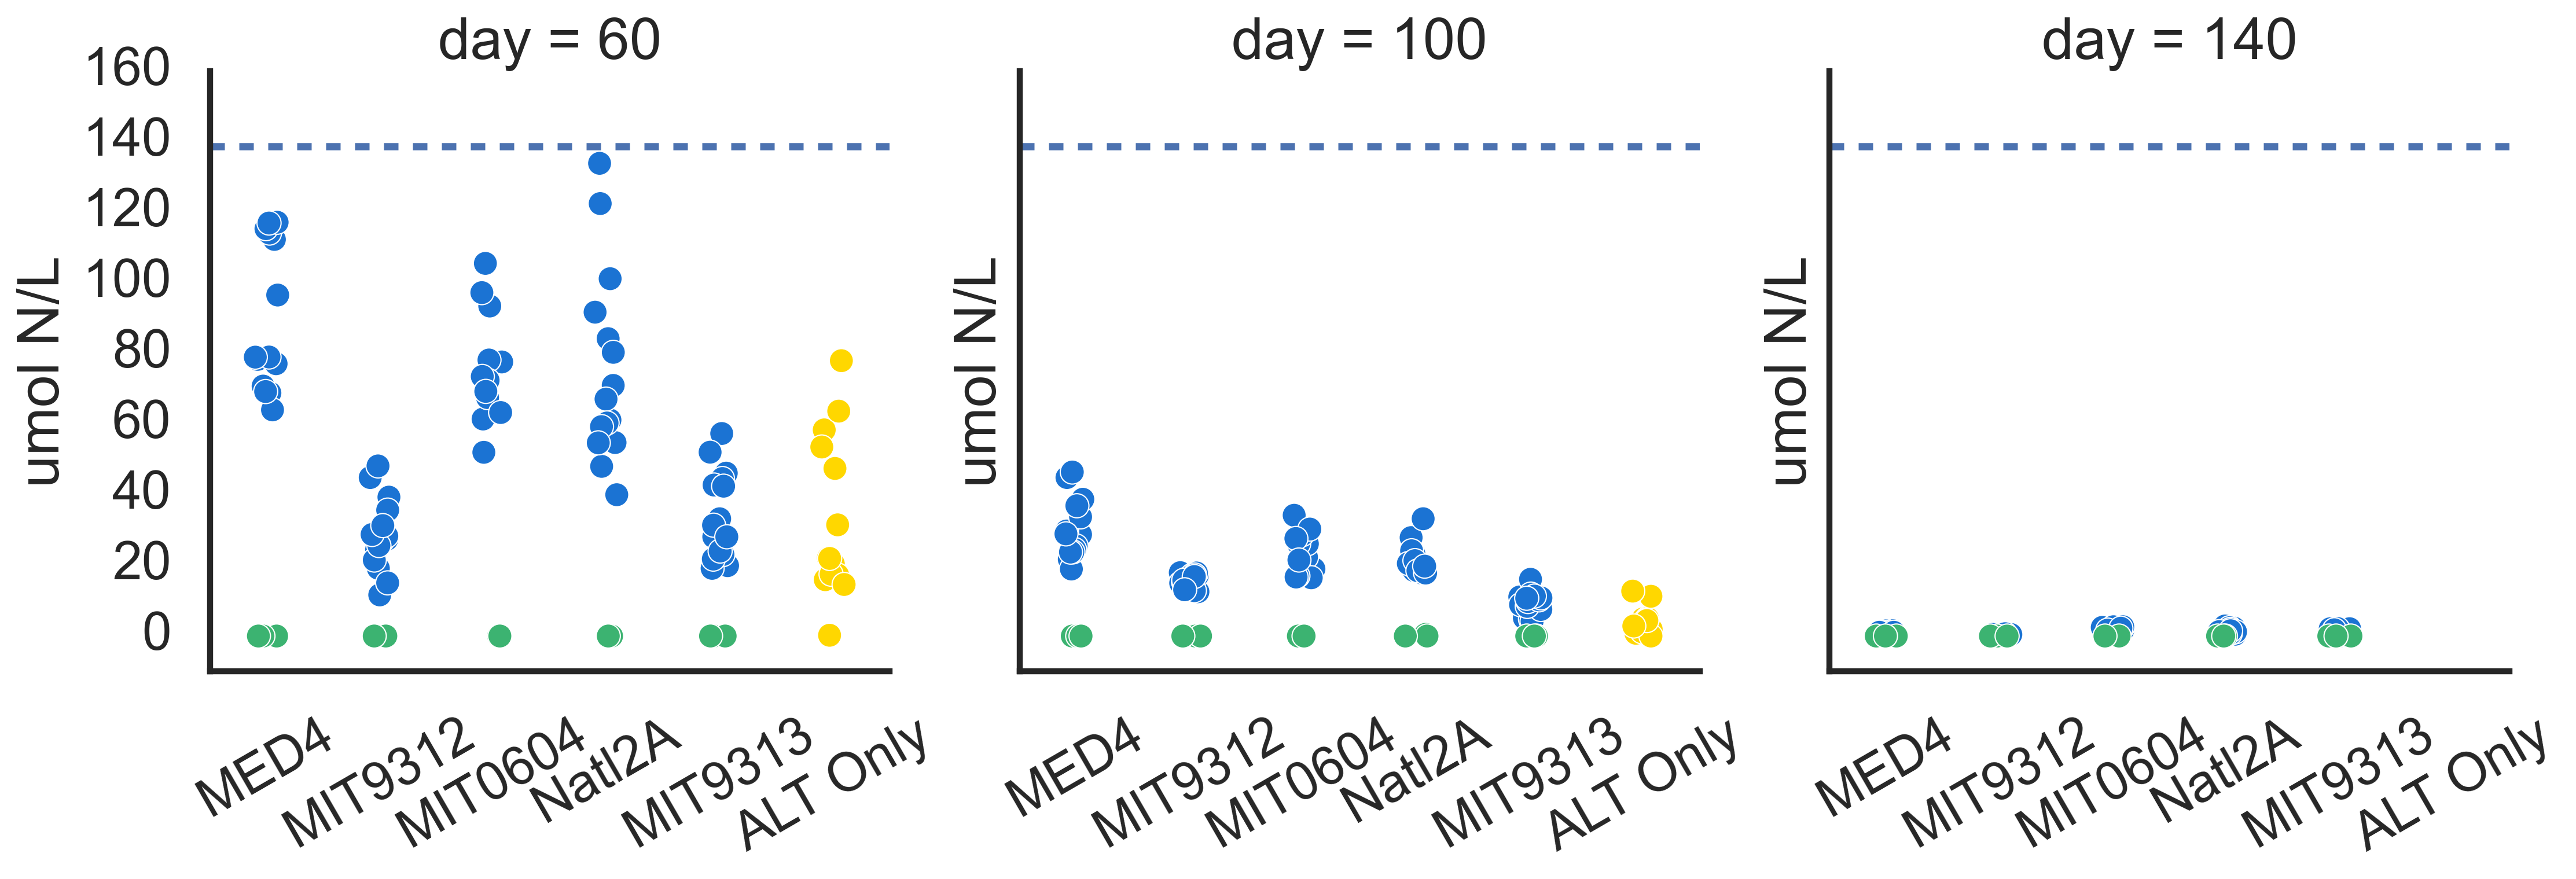

In [125]:

g = sns.catplot(data=mdf.loc[mdf.variable.isin(['N[Total] min', #'N[Total] max'
                                               ])],
            hue='culture', y='value', #hue='culture', 
            col='day',x='PRO',
            #kind='box', 
            #kind='box',
            order=porder + ['ALT Only'],
            palette=['#1B73D3', PRO_COLOR, ALT_COLOR, ], hue_order=['Co_Culture', 'PRO Only', 'ALT Only', ],

            #hue_order=porder + ['ALT Only'],
            #palette=ppallete + ['grey'], 
                edgecolor='white', linewidth=0.5,
            dodge=False,
                legend=False,
            #sharey=False, #
                s=10, 
           ).set(ylabel='umol N/L', xlabel='', 
                 ylim=(-10, 160)
                 #yscale='log'
                ).set_xticklabels(rotation=30) 
for ax in g.axes.flat:
    ax.axhline(initial_N_max, ls='--', label='Total N in media')

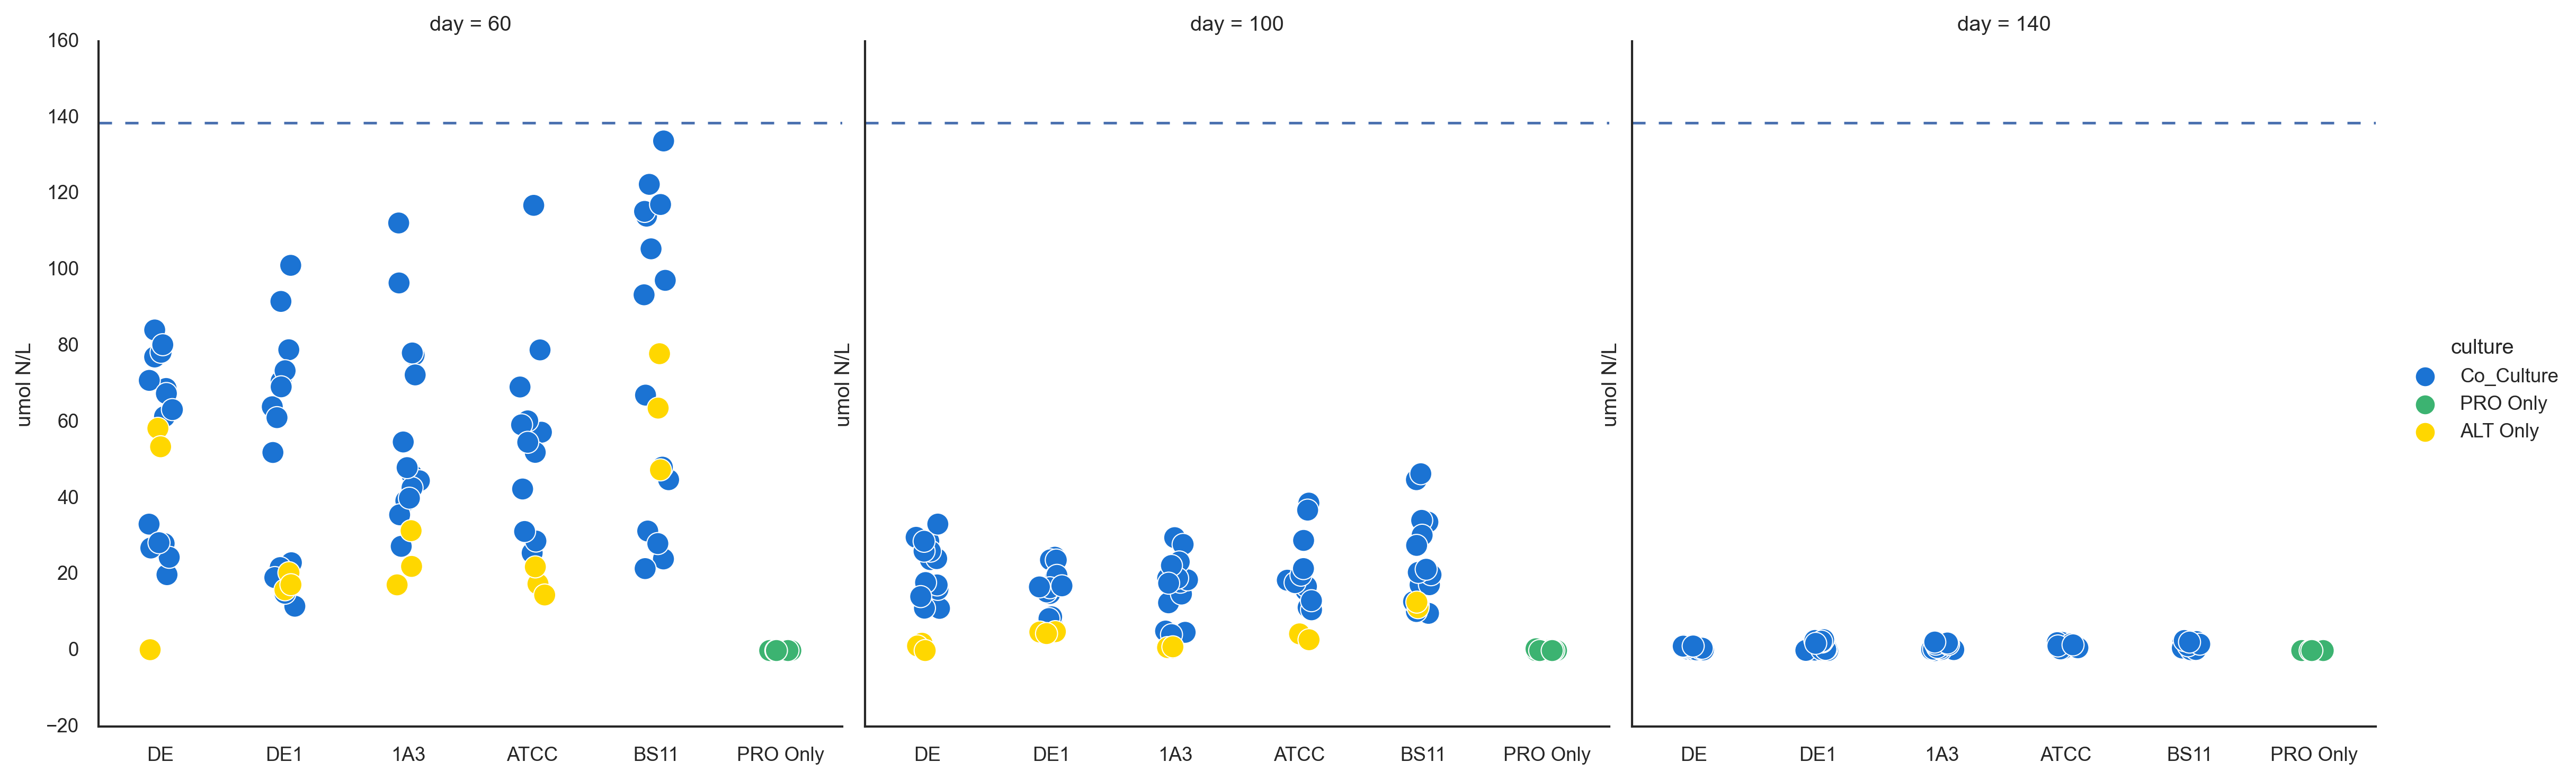

In [66]:

sns.set_context('paper')
g = sns.catplot(data=mdf.loc[mdf.variable.isin(['N[Total] min', #'N[Total] max'
                                               ])],
            hue='culture', y='value', #hue='culture', 
            col='day',x='ALT',
            #kind='box', 
            #kind='box',
            order=aorder + ['PRO Only'],
            palette=['#1B73D3', PRO_COLOR, ALT_COLOR, ], hue_order=['Co_Culture', 'PRO Only', 'ALT Only', ],

            #hue_order=porder + ['ALT Only'],
            #palette=ppallete + ['grey'], 
                edgecolor='white', linewidth=0.5,
            dodge=False,
            #sharey=False, 
                s=10, 
           ).set(ylabel='umol N/L', xlabel='', 
                 #ylim=(-200, 2500)
                 #yscale='log'
                )
for ax in g.axes.flat:
    ax.axhline(initial_N_max, ls='--', label='Total N in media')

In [67]:
initial_N_max

138.57142857142858

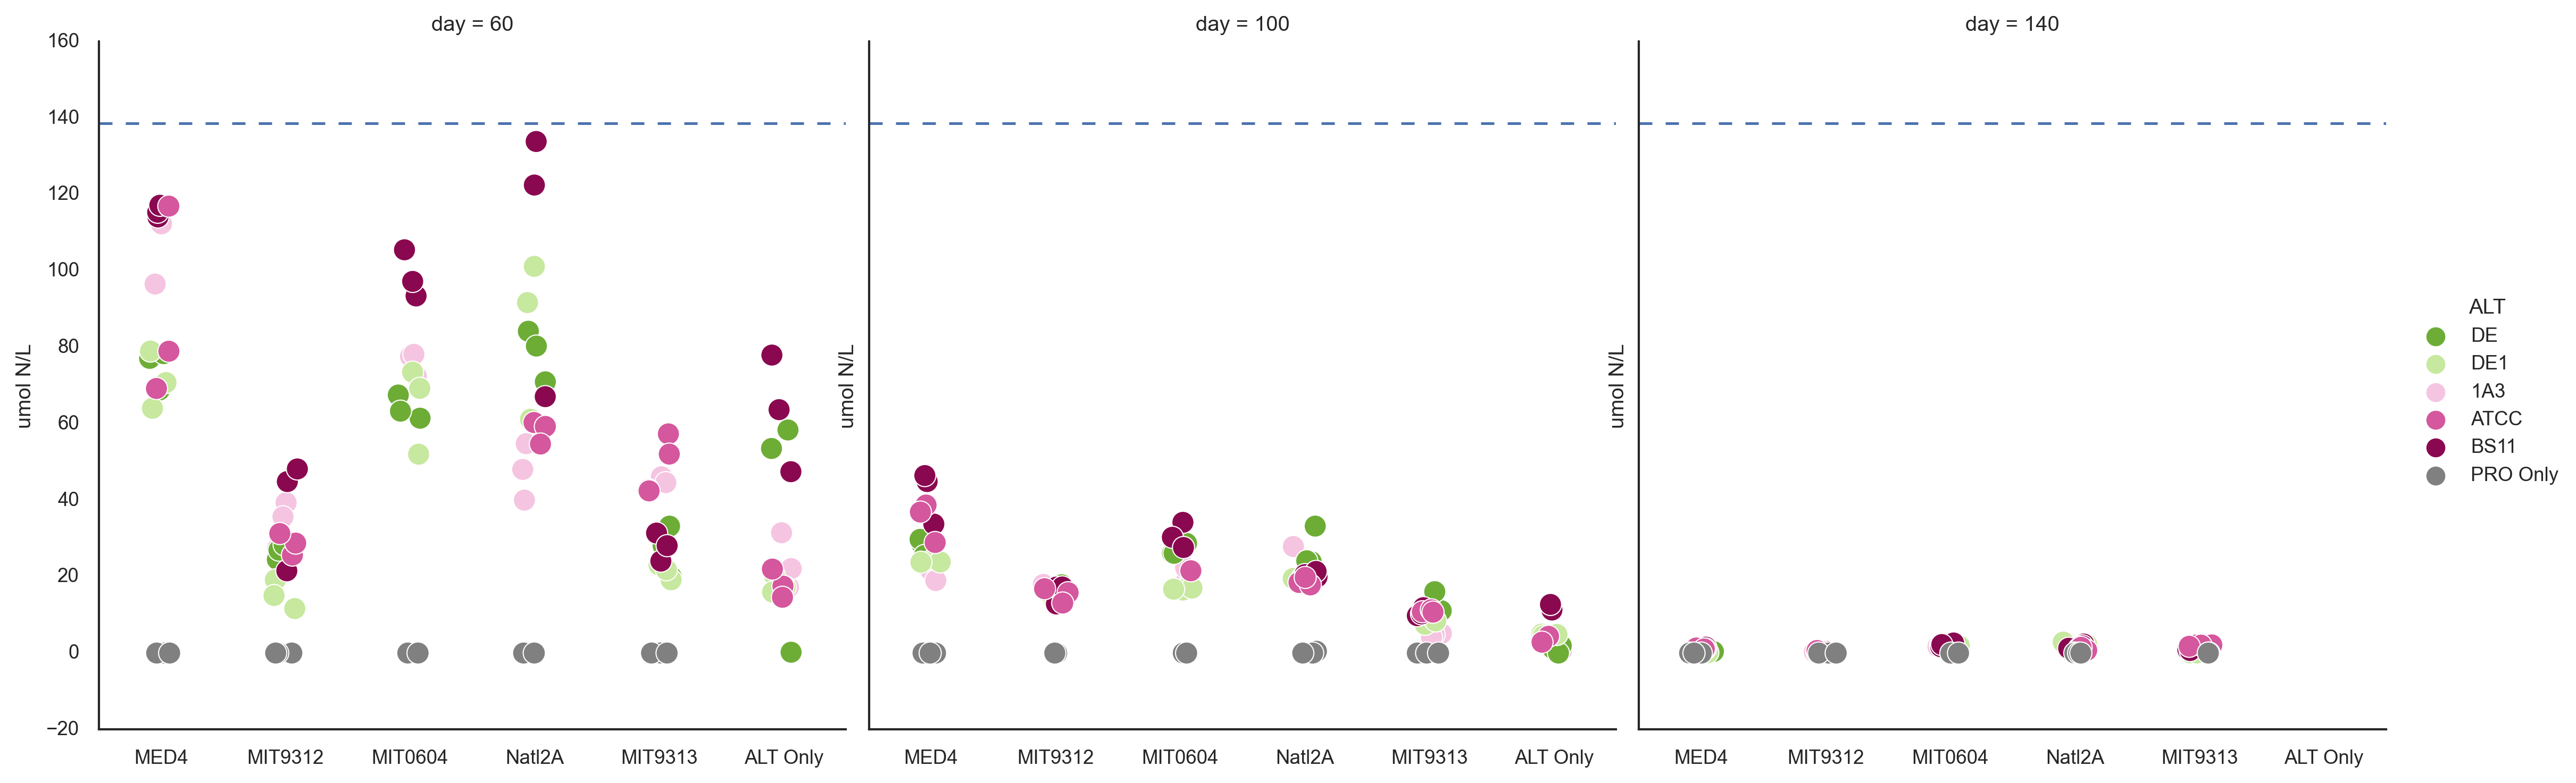

In [68]:

sns.set_context('paper')
g = sns.catplot(data=mdf.loc[mdf.variable.isin(['N[Total] min', #'N[Total] max'
                                               ])],
            hue='ALT', y='value', #hue='culture', 
            col='day',x='PRO',
            #kind='box', 
            #kind='swarm',
            order=porder + ['ALT Only'],
            #palette=['#1B73D3', PRO_COLOR, ALT_COLOR, ], hue_order=['Co_Culture', 'PRO Only', 'ALT Only', ],

            hue_order=aorder + ['PRO Only'],
            palette=apallete + ['grey'], 
            dodge=False,
            #sharey=False,
                s=10, 
                edgecolor='white', linewidth=0.5,
           ).set(ylabel='umol N/L', xlabel='', 
                 #ylim=(-200, 2500)
                 #yscale='log'
                )
for ax in g.axes.flat:
    ax.axhline(initial_N_max, ls='--', label='Total N in media')

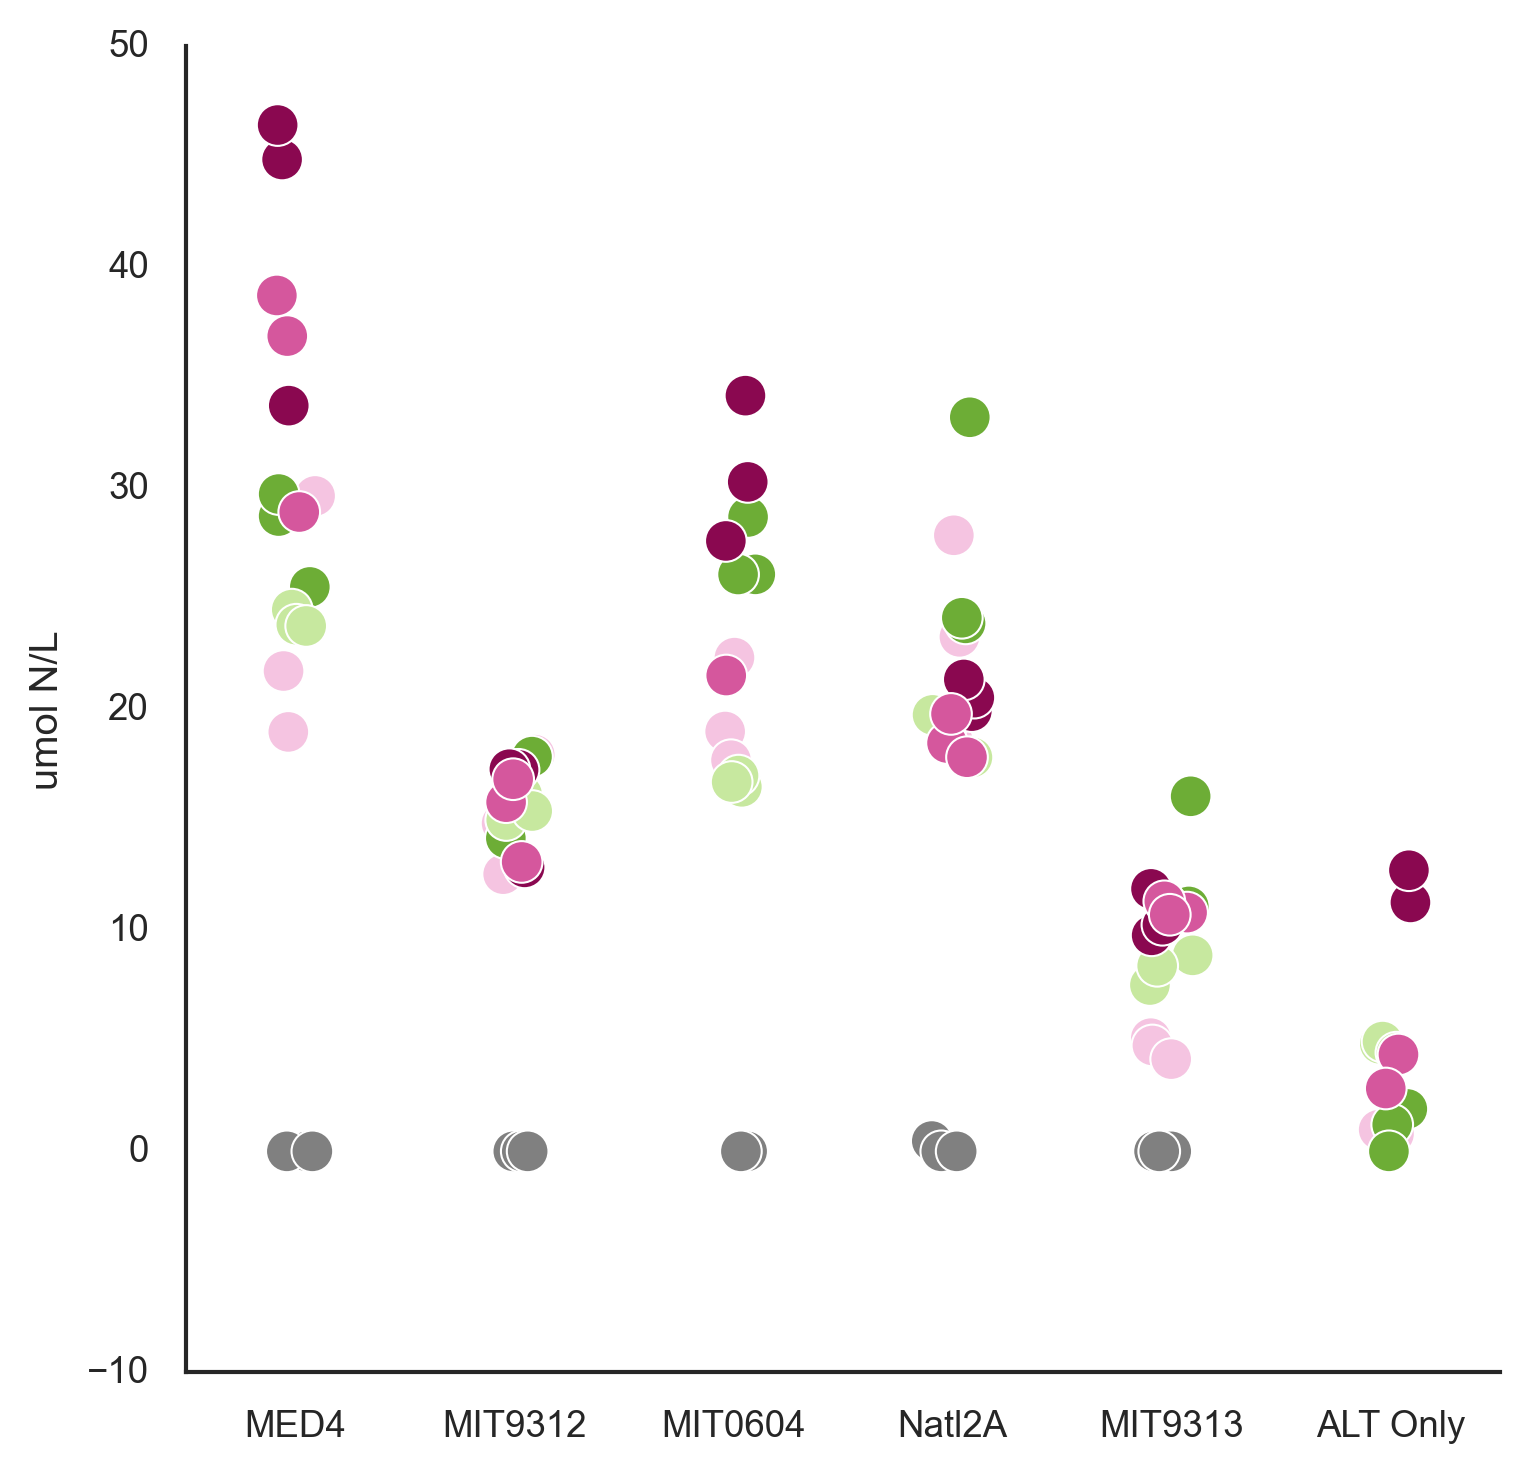

In [69]:

sns.set_context('paper')
g = sns.catplot(data=mdf.loc[mdf.variable.isin(['N[Total] min', #'N[Total] max'
                                               ]) &
                             (mdf.day == 100)
                                               ],
            hue='ALT', y='value', #hue='culture', 
            x='PRO',
            #kind='box', 
            #kind='swarm',
            order=porder + ['ALT Only'],
            #palette=['#1B73D3', PRO_COLOR, ALT_COLOR, ], hue_order=['Co_Culture', 'PRO Only', 'ALT Only', ],

            hue_order=aorder + ['PRO Only'],
            palette=apallete + ['grey'], 
            dodge=False,
            sharey=False,
                s=10,
                edgecolor='white', linewidth=0.5,
                legend=False,
           ).set(ylabel='umol N/L', xlabel='', 
                 #ylim=(-200, 2500)
                 #yscale='log'
                )
#for ax in g.axes.flat:
#    ax.axhline(initial_N_max, ls='--', label='Total N in media')

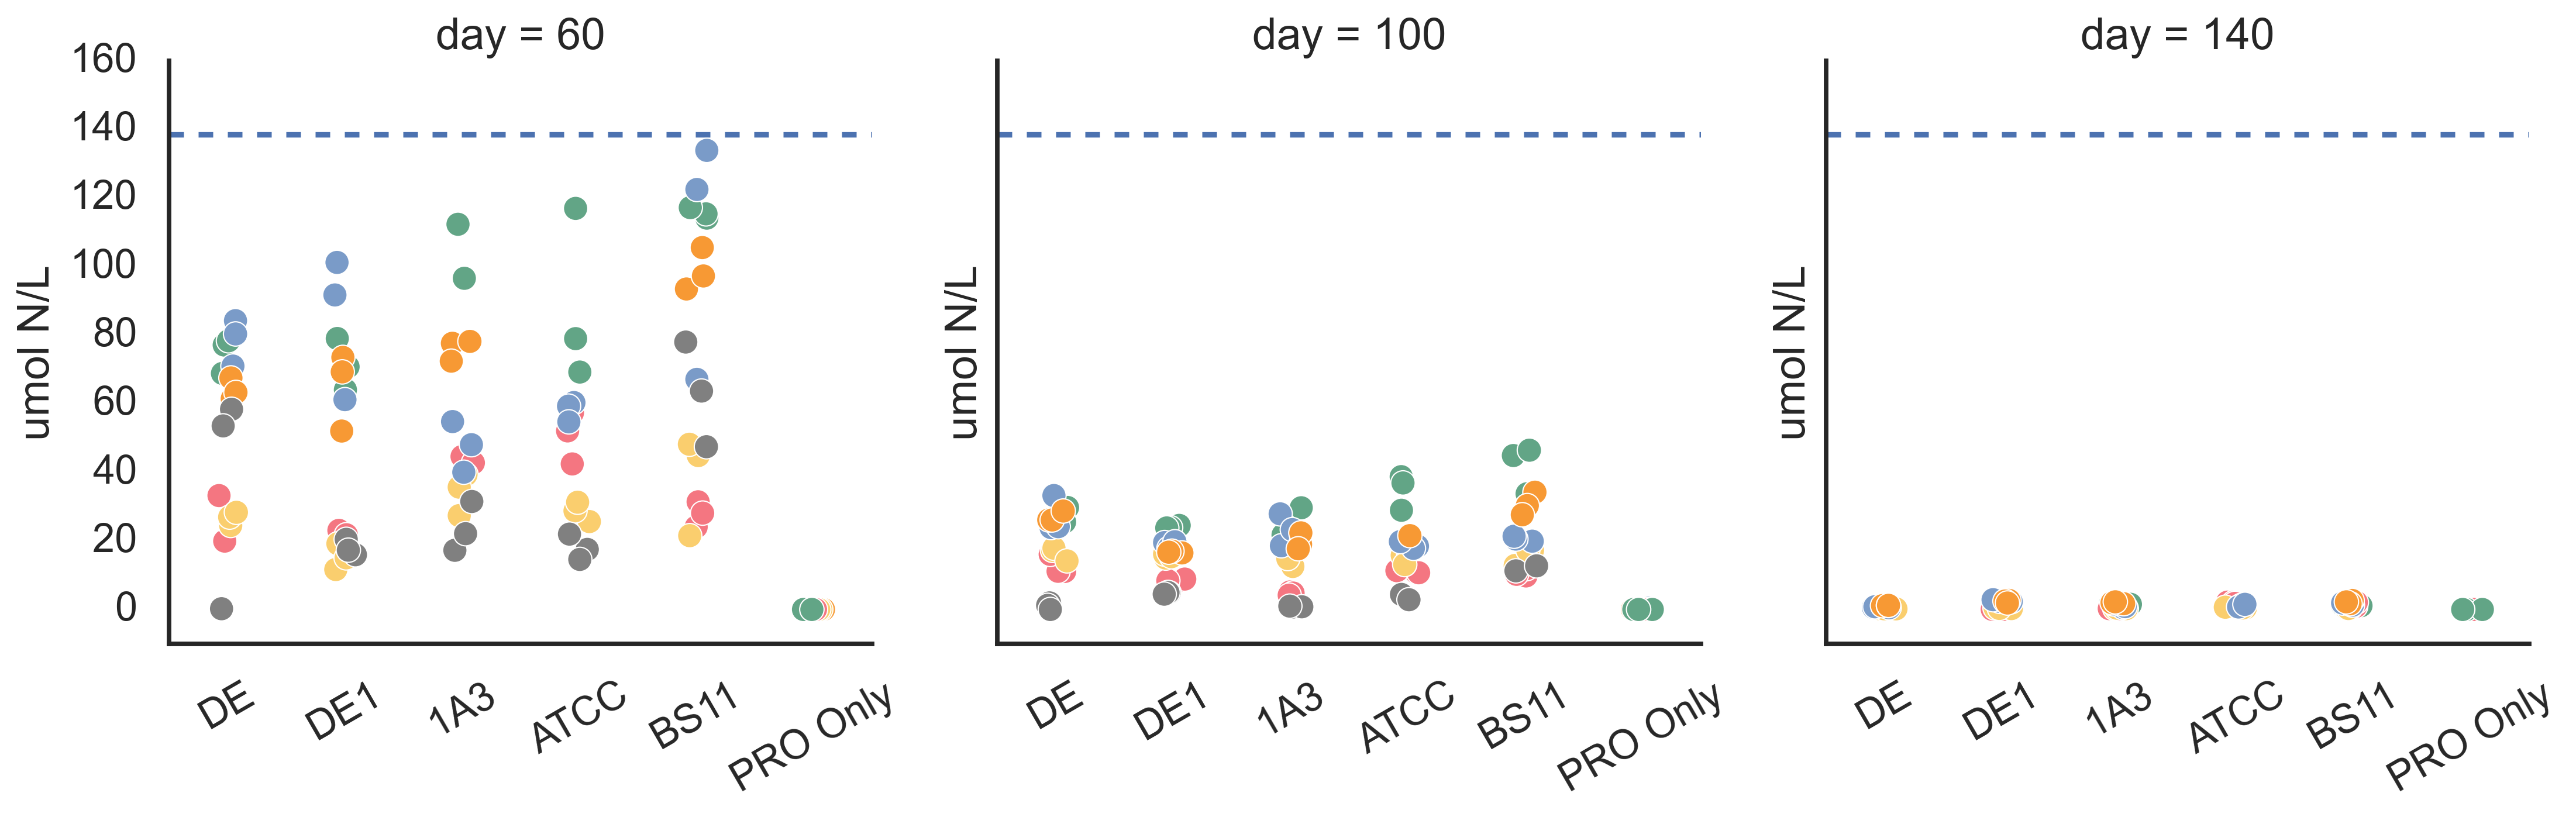

In [137]:
sns.set_context('talk')
g = sns.catplot(data=mdf.loc[mdf.variable.isin(['N[Total] min', #'N[Total] max'
                                               ]) ],
            hue='PRO', y='value', #hue='culture', 
            col='day',x='ALT',
            #kind='box', 
            #kind='swarm',
            order=aorder + ['PRO Only'],
            #palette=['#1B73D3', PRO_COLOR, ALT_COLOR, ], hue_order=['Co_Culture', 'PRO Only', 'ALT Only', ],

            hue_order=porder + ['ALT Only'],
            palette=ppallete + ['grey'], 
            dodge=False,
            #sharey=False,
                edgecolor='white', linewidth=0.5,
                s=10, 
                legend=False
           ).set(ylabel='umol N/L', xlabel='', 
                 ylim=(-10, 160)
                 #yscale='log'
                ).set_xticklabels(rotation=30) 
          
plt.tight_layout()
for ax in g.axes.flat:
    ax.axhline(initial_N_max, ls='--', label='Total N in media')

In [138]:
df.loc[(df.day == 60) & df.ALT.isin(['DE'])]

,PRO,ALT,sample,PRO.1,ALT.1,experiment,day,culture,pair,C[PRO] min,...,C[ALT] min,C[ALT] max,N[ALT] min,N[ALT] max,C[Total] min,C[Total] max,N[Total] min,N[Total] max,totalN,percent_N
15,MED4,DE,6A,1.456221e+07,7.021021e+07,exp1,60,Co_Culture,"MED4,DE",20.629800,...,327.647631,514.874848,65.195192,125.375369,348.277431,575.550731,68.835745,135.776949,68.835745,0.496753
16,MED4,DE,6B,1.398733e+07,7.927801e+07,exp1,60,Co_Culture,"MED4,DE",19.815380,...,369.964034,581.372053,73.615292,141.567870,389.779414,639.652583,77.112124,151.558818,77.112124,0.556479
17,MED4,DE,6C,1.757373e+07,7.963864e+07,exp1,60,Co_Culture,"MED4,DE",24.896121,...,371.646983,584.016687,73.950165,142.211856,396.543104,657.240573,78.343598,154.764522,78.343598,0.565366
18,MIT9313,DE,7A,5.753456e+06,1.991616e+07,exp1,60,Co_Culture,"MIT9313,DE",8.150730,...,92.942082,146.051843,18.493578,35.564572,101.092811,170.024577,19.931942,39.674184,19.931942,0.143839
19,MIT9313,DE,7B,6.023963e+06,3.413973e+07,exp1,60,Co_Culture,"MIT9313,DE",8.533948,...,159.318753,250.358040,31.701180,60.963808,167.852700,275.457886,33.207171,65.266639,33.207171,0.239639
20,MIT9313,DE,7C,6.305530e+06,2.856233e+07,exp1,60,Co_Culture,"MIT9313,DE",8.932834,...,133.290887,209.457108,26.522166,51.004166,142.223721,235.730150,28.098549,55.508116,28.098549,0.202773
21,MIT9312,DE,8A,1.504931e+07,2.232588e+07,exp1,60,Co_Culture,"MIT9312,DE",21.319854,...,104.187444,163.723127,20.731175,39.867644,125.507298,226.428580,24.493502,50.617151,24.493502,0.176757
22,MIT9312,DE,8B,1.526406e+07,2.489648e+07,exp1,60,Co_Culture,"MIT9312,DE",21.624078,...,116.183556,182.574160,23.118157,44.457993,137.807634,246.174390,26.934170,55.360890,26.934170,0.194370
23,MIT9312,DE,8C,1.622212e+07,2.614022e+07,exp1,60,Co_Culture,"MIT9312,DE",22.981336,...,121.987687,191.694937,24.273060,46.678962,144.969024,259.287103,28.328590,58.266190,28.328590,0.204433
24,Natl2A,DE,9A,4.849539e+07,7.763038e+07,exp1,60,Co_Culture,"Natl2A,DE",68.701805,...,362.275091,569.289429,72.085350,138.625673,430.976896,771.353561,84.209198,173.265238,84.209198,0.607695


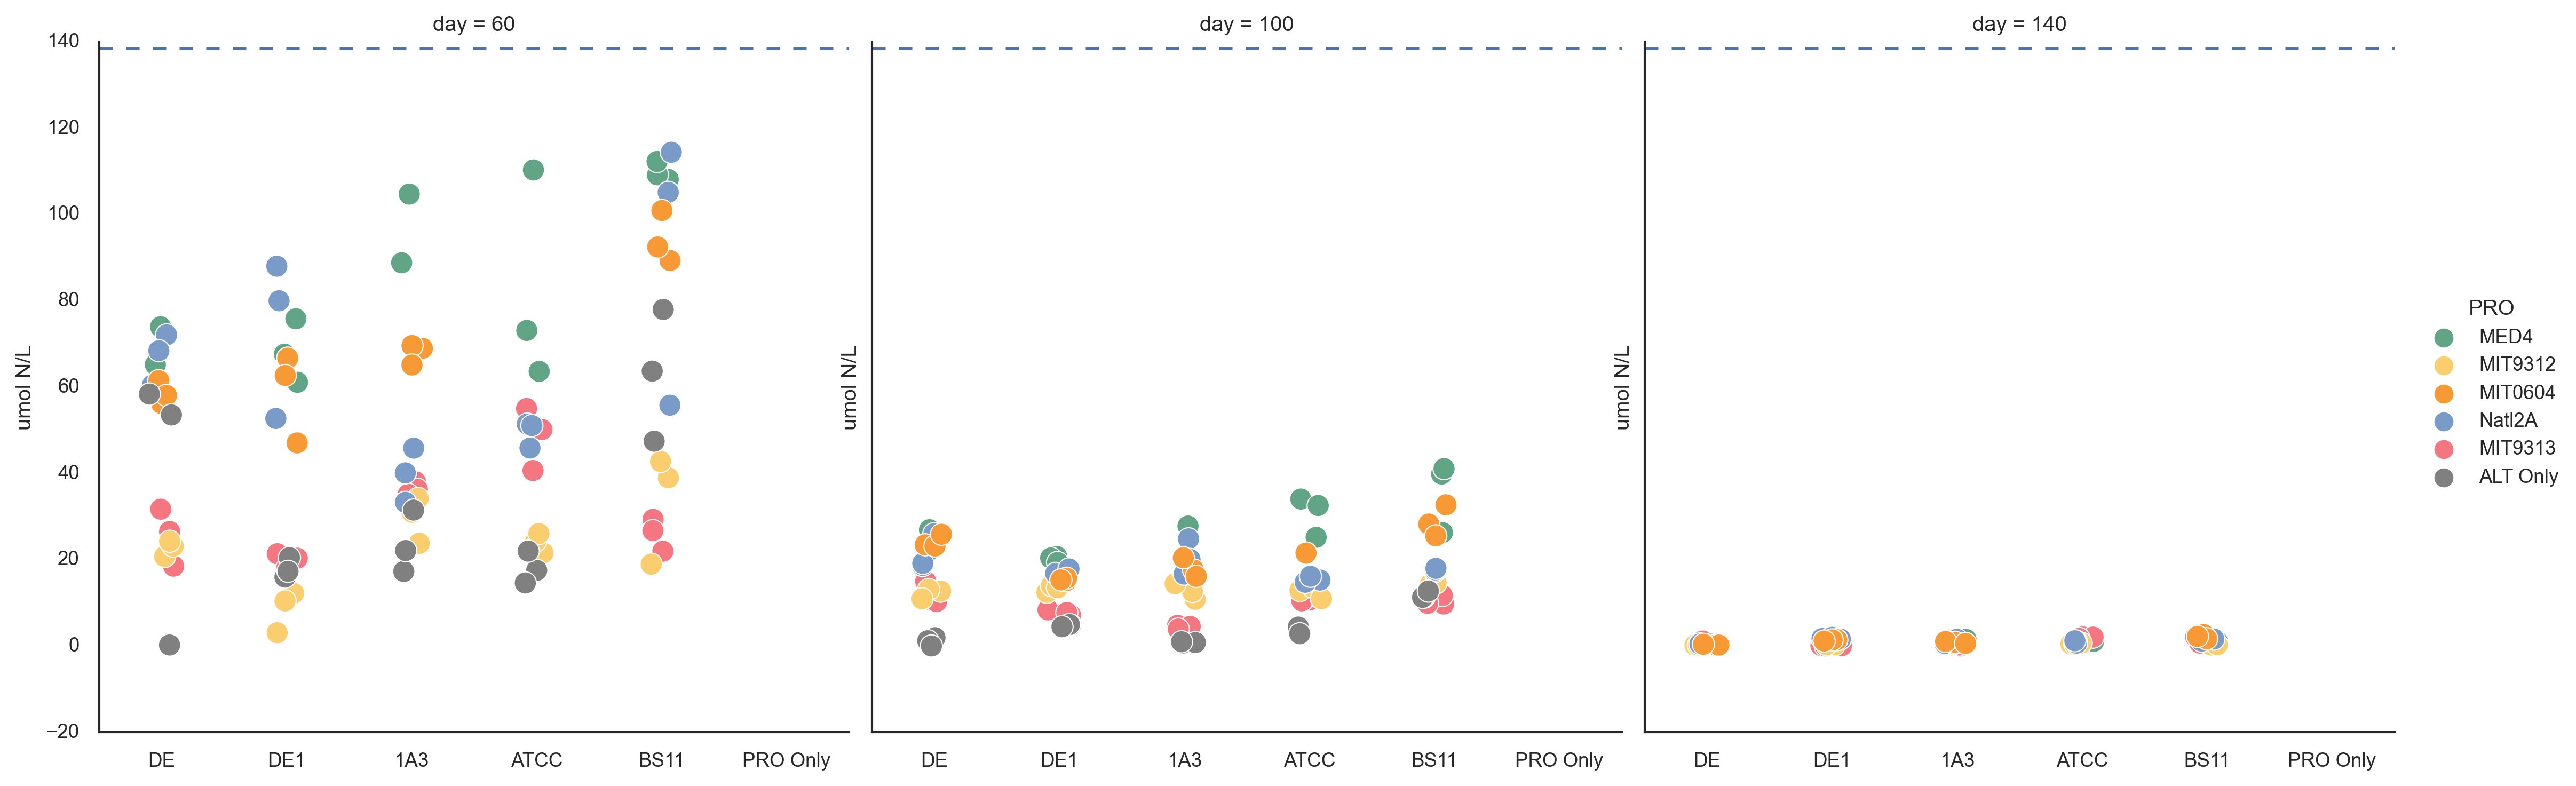

In [71]:

sns.set_context('paper')
g = sns.catplot(data=mdf.loc[mdf.variable.isin(['N[ALT] min', #'N[Total] max'
                                               ]) ],
            hue='PRO', y='value', #hue='culture', 
            col='day',x='ALT',
            #kind='box', 
            #kind='swarm',
            order=aorder + ['PRO Only'],
            #palette=['#1B73D3', PRO_COLOR, ALT_COLOR, ], hue_order=['Co_Culture', 'PRO Only', 'ALT Only', ],

            hue_order=porder + ['ALT Only'],
            palette=ppallete + ['grey'], 
            dodge=False,
            #sharey=False,
                edgecolor='white', linewidth=0.5,
                s=10, 
           ).set(ylabel='umol N/L', xlabel='', 
                 #ylim=(-200, 2500)
                 #yscale='log'
                )
for ax in g.axes.flat:
    ax.axhline(initial_N_max, ls='--', label='Total N in media')

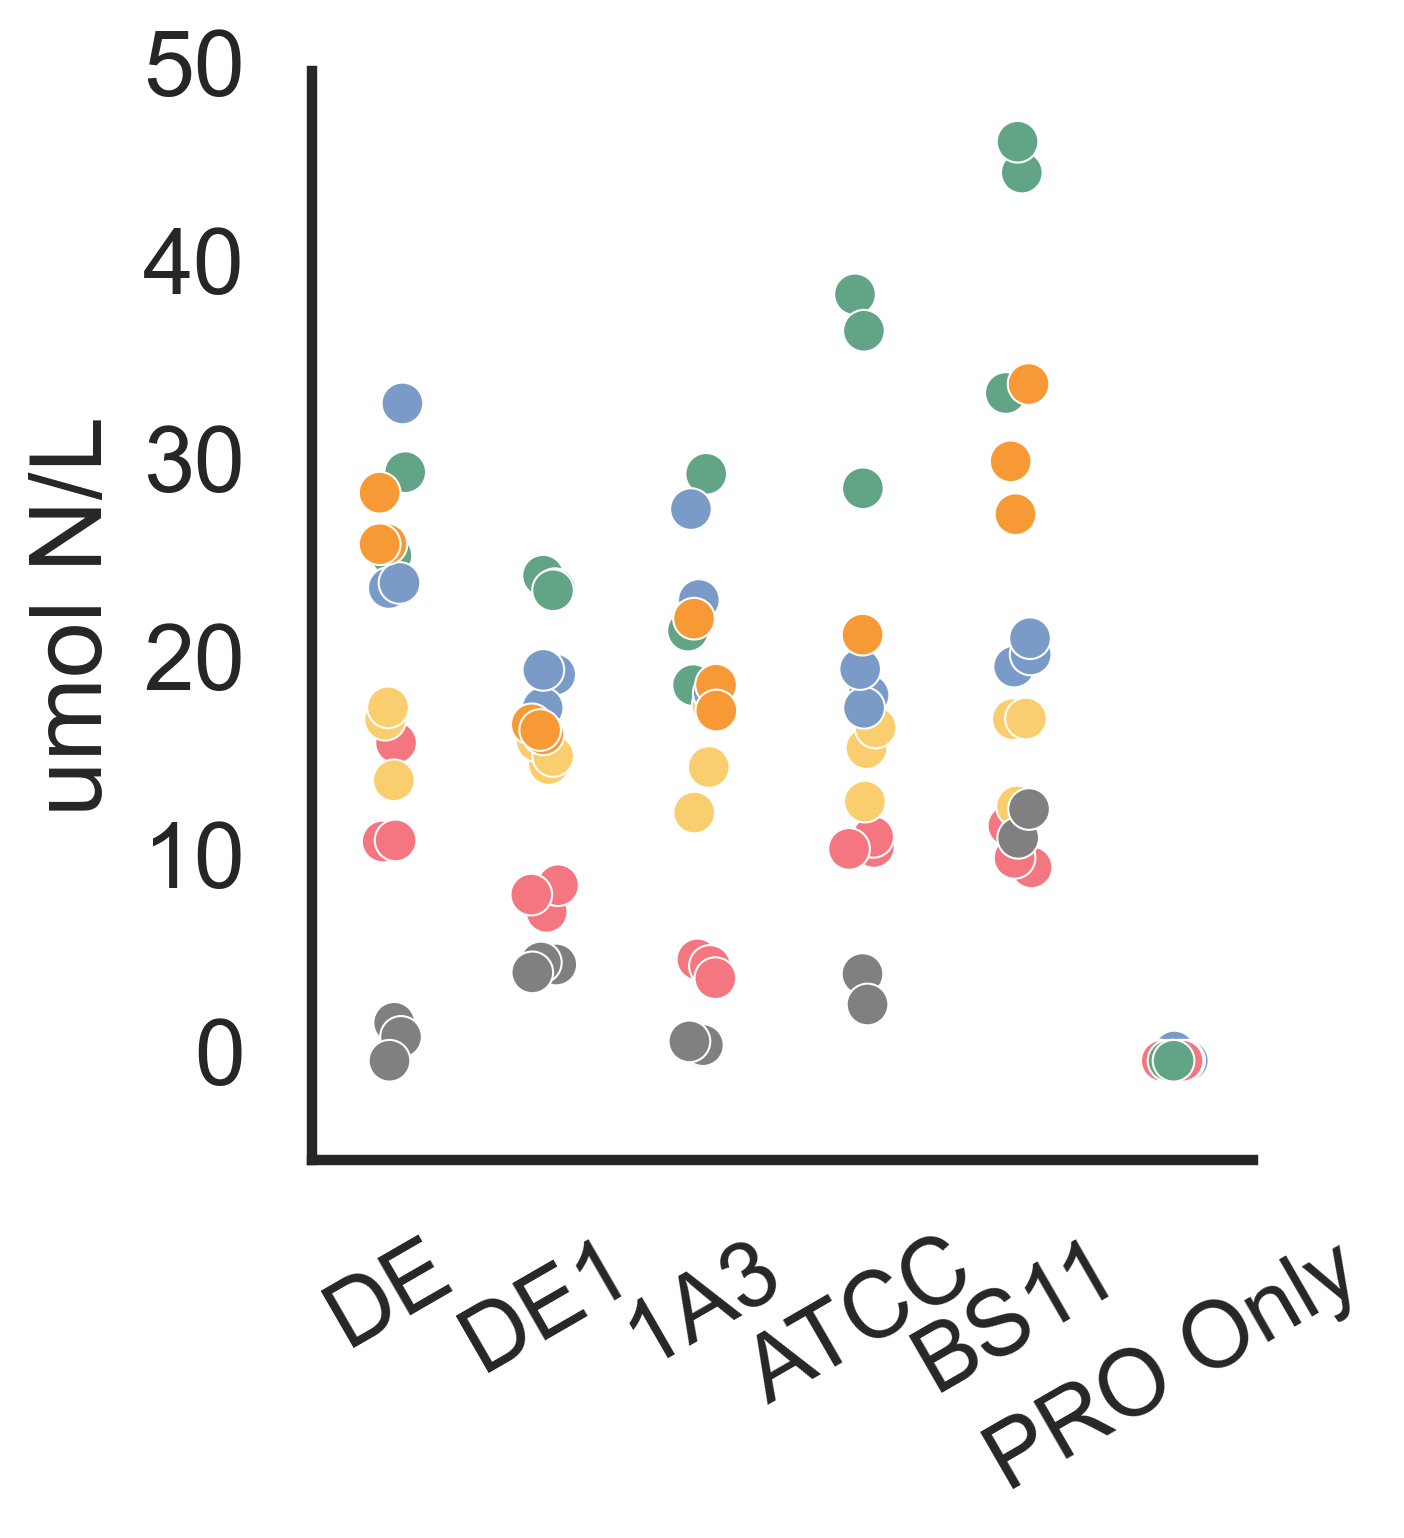

In [133]:

g = sns.catplot(data=mdf.loc[mdf.variable.isin(['N[Total] min', #'N[Total] max'
                                               ]) &
                             (mdf.day == 100)
                            ],
            hue='PRO', y='value', #hue='culture', 
            x='ALT',
            #kind='box', 
            #kind='swarm',
            order=aorder + ['PRO Only'],
            #palette=['#1B73D3', PRO_COLOR, ALT_COLOR, ], hue_order=['Co_Culture', 'PRO Only', 'ALT Only', ],

            hue_order=porder + ['ALT Only'],
            palette=ppallete + ['grey'], 
            dodge=False,
                edgecolor='white', linewidth=0.5,
            sharey=False,
                legend=False,
                s=10, 
           ).set(ylabel='umol N/L', xlabel='', 
                 ylim=(-5, 50)
                 #yscale='log'
                ).set_xticklabels(rotation=30) 
#for ax in g.axes.flat:
#    ax.axhline(initial_N_max, ls='--', label='Total N in media')

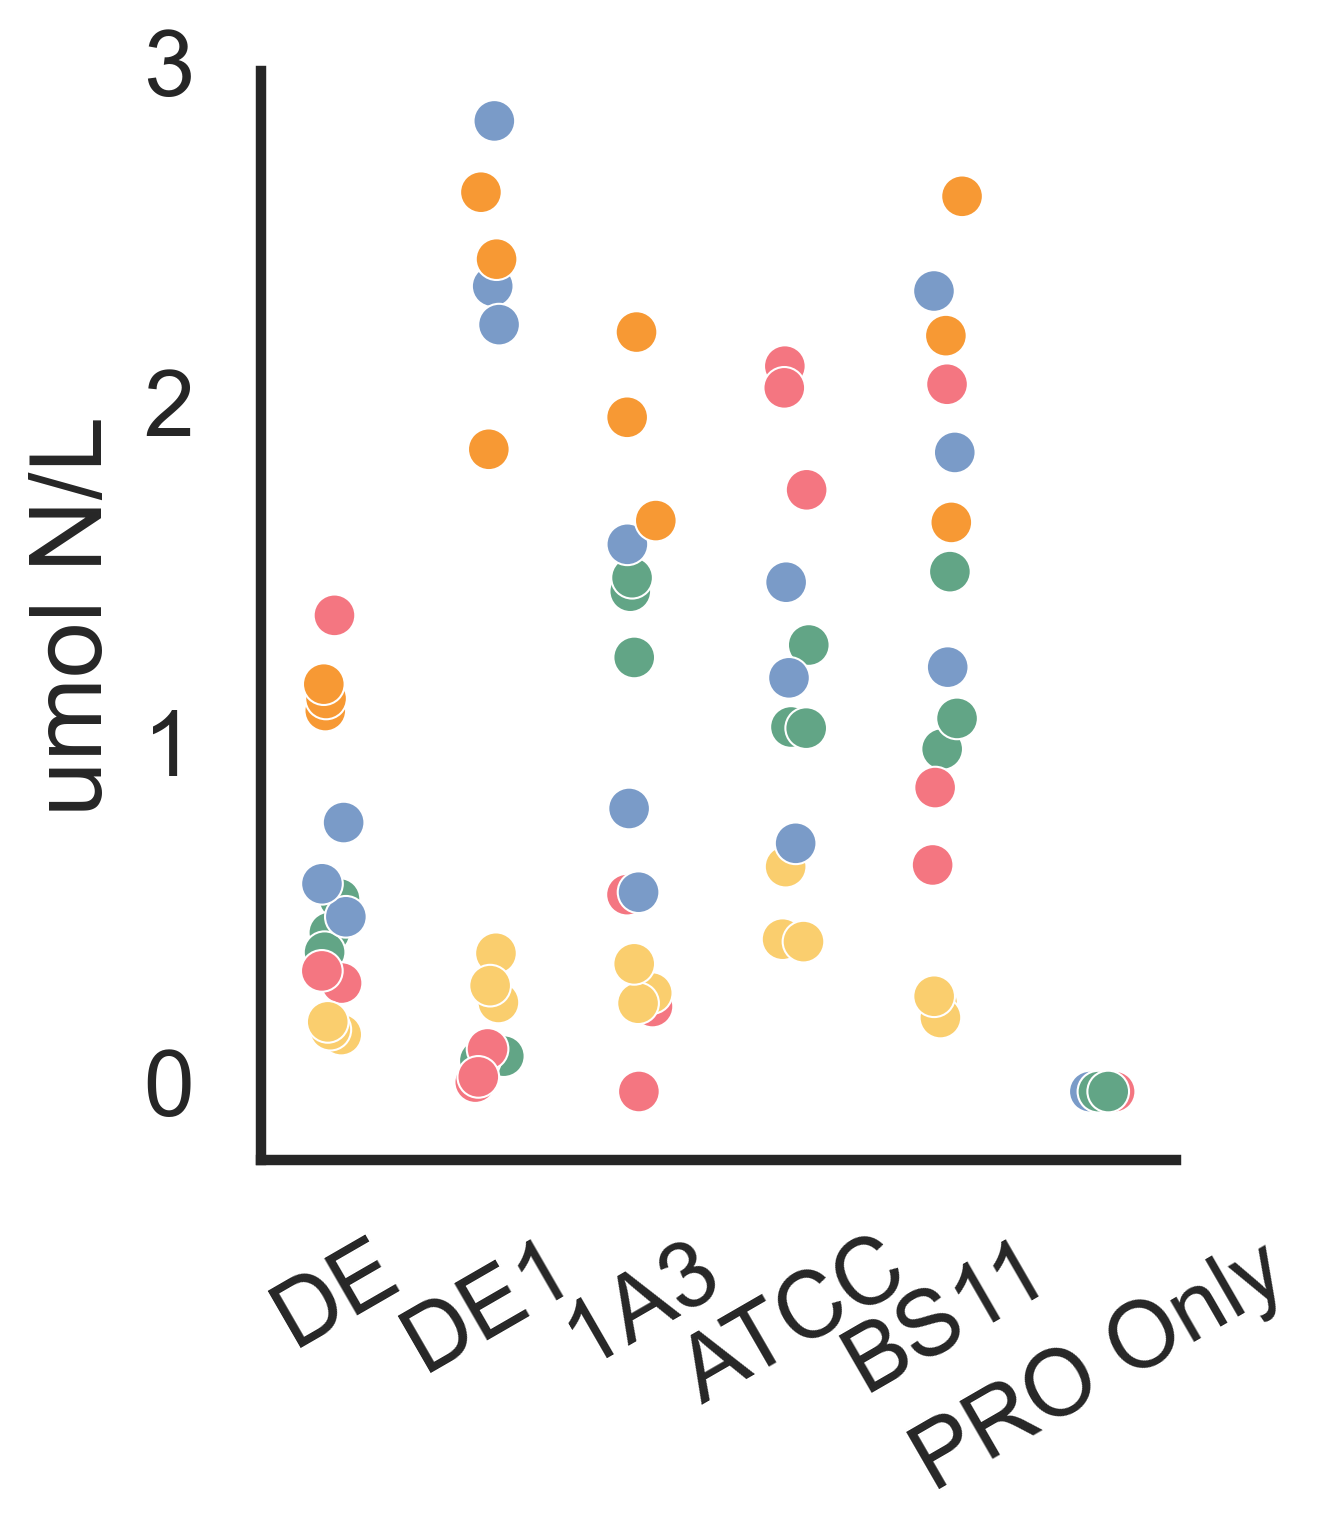

In [136]:

g = sns.catplot(data=mdf.loc[mdf.variable.isin(['N[Total] min', #'N[Total] max'
                                               ]) &
                             (mdf.day == 140)
                            ],
            hue='PRO', y='value', #hue='culture', 
            x='ALT',
            #kind='box', 
            #kind='swarm',
            order=aorder + ['PRO Only'],
            #palette=['#1B73D3', PRO_COLOR, ALT_COLOR, ], hue_order=['Co_Culture', 'PRO Only', 'ALT Only', ],

            hue_order=porder + ['ALT Only'],
            palette=ppallete + ['grey'], 
            dodge=False,
                edgecolor='white', linewidth=0.5,
            sharey=False,
                legend=False,
                s=10, 
           ).set(ylabel='umol N/L', xlabel='', 
                 ylim=(-0.2, 3), yticks=[0,1,2,3]
                 #yscale='log'
                ).set_xticklabels(rotation=30) 
#for ax in g.axes.flat:
#    ax.axhline(initial_N_max, ls='--', label='Total N in media')

In [80]:
df['totalN']  = df['N[Total] min'] 

In [141]:
df['ALTN']  = df['N[ALT] min'] 

In [82]:
from statsmodels.formula.api import ols

#for i in porder:
dfdata=df #.loc[df.PRO.isin([p])]

mod = ols('totalN ~ C(PRO)',
                data=dfdata).fit()
#print (f'++++++++++++++++++ day = {d} +++++++++++++++++++++++')
print(mod.summary())
print(sm.stats.anova_lm(mod))
print(f'totalN as function of PRO strain')
pair_t = mod.t_test_pairwise("C(PRO)", method='b')
print(pair_t.result_frame)
print(f'totalN as function of PRO strain')
print(pair_t.result_frame.loc[pair_t.result_frame['reject-b'], 'pvalue-b'])
#aov_table = sm.stats.anova_lm(mod, typ=2)
#print(aov_table)

                            OLS Regression Results                            
Dep. Variable:                 totalN   R-squared:                       0.083
Model:                            OLS   Adj. R-squared:                  0.067
Method:                 Least Squares   F-statistic:                     5.068
Date:                Wed, 09 Mar 2022   Prob (F-statistic):           0.000183
Time:                        18:27:49   Log-Likelihood:                -1355.1
No. Observations:                 286   AIC:                             2722.
Df Residuals:                     280   BIC:                             2744.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            18.9629      5.27

In [87]:
df.columns

Index(['PRO', 'ALT', 'sample', 'PRO.1', 'ALT.1', 'experiment', 'day',
       'culture', 'pair', 'C[PRO] min', 'C[PRO] max', 'N[PRO] min',
       'N[PRO] max', 'C[ALT] min', 'C[ALT] max', 'N[ALT] min', 'N[ALT] max',
       'C[Total] min', 'C[Total] max', 'N[Total] min', 'N[Total] max',
       'totalN'],
      dtype='object')

In [ ]:
df['PRO1'] = df['PRO']

In [94]:
df.PRO.unique()

array(['MED4', 'MIT9313', 'MIT9312', 'Natl2A', 'MIT0604', 'ALT Only'],
      dtype=object)

In [95]:
from statsmodels.formula.api import ols

for a in aorder:
    dfdata=df.loc[df.ALT.isin([a]) & (df.day == 60)]

    mod = ols('totalN ~ C(PRO)',
                    data=dfdata).fit()
    print (f'++++++++++++++++++ {a} +++++++++++++++++++++++')
    print(mod.summary())
    print(sm.stats.anova_lm(mod))
    print(f'=== {a} === totalN as function of ALT strain')
    pair_t = mod.t_test_pairwise("C(PRO)", method='b')
    print(pair_t.result_frame)
    print(f'=== {a} === totalN as function of PRO strain')
    print(pair_t.result_frame.loc[pair_t.result_frame['reject-b'], 'pvalue-b'])
    #aov_table = sm.stats.anova_lm(mod, typ=2)
    #print(aov_table)

++++++++++++++++++ DE +++++++++++++++++++++++
                            OLS Regression Results                            
Dep. Variable:                 totalN   R-squared:                       0.784
Model:                            OLS   Adj. R-squared:                  0.695
Method:                 Least Squares   F-statistic:                     8.736
Date:                Wed, 09 Mar 2022   Prob (F-statistic):            0.00108
Time:                        18:38:06   Log-Likelihood:                -69.368
No. Observations:                  18   AIC:                             150.7
Df Residuals:                      12   BIC:                             156.1
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------

C:\Users\wosnat\Anaconda3\lib\site-packages\scipy\stats\stats.py:1604: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  "anyway, n=%i" % int(n))
C:\Users\wosnat\Anaconda3\lib\site-packages\scipy\stats\stats.py:1604: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  "anyway, n=%i" % int(n))
C:\Users\wosnat\Anaconda3\lib\site-packages\scipy\stats\stats.py:1604: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=17
  "anyway, n=%i" % int(n))
C:\Users\wosnat\Anaconda3\lib\site-packages\scipy\stats\stats.py:1604: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  "anyway, n=%i" % int(n))
C:\Users\wosnat\Anaconda3\lib\site-packages\scipy\stats\stats.py:1604: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  "anyway, n=%i" % int(n))


In [142]:
from statsmodels.formula.api import ols

for a in aorder:
    dfdata=df.loc[df.ALT.isin([a]) & (df.day == 60)]

    mod = ols('ALTN ~ C(PRO)',
                    data=dfdata).fit()
    print (f'++++++++++++++++++ {a} +++++++++++++++++++++++')
    print(mod.summary())
    print(sm.stats.anova_lm(mod))
    print(f'=== {a} === totalN as function of ALT strain')
    pair_t = mod.t_test_pairwise("C(PRO)", method='b')
    print(pair_t.result_frame)
    print(f'=== {a} === totalN as function of PRO strain')
    print(pair_t.result_frame.loc[pair_t.result_frame['reject-b'], 'pvalue-b'])
    #aov_table = sm.stats.anova_lm(mod, typ=2)
    #print(aov_table)

++++++++++++++++++ DE +++++++++++++++++++++++
                            OLS Regression Results                            
Dep. Variable:                   ALTN   R-squared:                       0.745
Model:                            OLS   Adj. R-squared:                  0.638
Method:                 Least Squares   F-statistic:                     7.000
Date:                Thu, 10 Mar 2022   Prob (F-statistic):            0.00281
Time:                        09:25:33   Log-Likelihood:                -69.239
No. Observations:                  18   AIC:                             150.5
Df Residuals:                      12   BIC:                             155.8
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------

C:\Users\wosnat\Anaconda3\lib\site-packages\scipy\stats\stats.py:1604: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  "anyway, n=%i" % int(n))
C:\Users\wosnat\Anaconda3\lib\site-packages\scipy\stats\stats.py:1604: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  "anyway, n=%i" % int(n))
C:\Users\wosnat\Anaconda3\lib\site-packages\scipy\stats\stats.py:1604: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=17
  "anyway, n=%i" % int(n))
C:\Users\wosnat\Anaconda3\lib\site-packages\scipy\stats\stats.py:1604: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  "anyway, n=%i" % int(n))
C:\Users\wosnat\Anaconda3\lib\site-packages\scipy\stats\stats.py:1604: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  "anyway, n=%i" % int(n))


In [96]:
from statsmodels.formula.api import ols

for a in aorder:
    dfdata=df.loc[df.ALT.isin([a]) & (df.day == 100)]

    mod = ols('totalN ~ C(PRO)',
                    data=dfdata).fit()
    print (f'++++++++++++++++++ {a} +++++++++++++++++++++++')
    print(mod.summary())
    print(sm.stats.anova_lm(mod))
    print(f'=== {a} === totalN as function of ALT strain')
    pair_t = mod.t_test_pairwise("C(PRO)", method='b')
    print(pair_t.result_frame)
    print(f'=== {a} === totalN as function of PRO strain')
    print(pair_t.result_frame.loc[pair_t.result_frame['reject-b'], 'pvalue-b'])
    #aov_table = sm.stats.anova_lm(mod, typ=2)
    #print(aov_table)

++++++++++++++++++ DE +++++++++++++++++++++++
                            OLS Regression Results                            
Dep. Variable:                 totalN   R-squared:                       0.947
Model:                            OLS   Adj. R-squared:                  0.925
Method:                 Least Squares   F-statistic:                     43.02
Date:                Wed, 09 Mar 2022   Prob (F-statistic):           2.98e-07
Time:                        19:28:45   Log-Likelihood:                -40.670
No. Observations:                  18   AIC:                             93.34
Df Residuals:                      12   BIC:                             98.68
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------

C:\Users\wosnat\Anaconda3\lib\site-packages\scipy\stats\stats.py:1604: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  "anyway, n=%i" % int(n))
C:\Users\wosnat\Anaconda3\lib\site-packages\scipy\stats\stats.py:1604: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  "anyway, n=%i" % int(n))
C:\Users\wosnat\Anaconda3\lib\site-packages\scipy\stats\stats.py:1604: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  "anyway, n=%i" % int(n))
C:\Users\wosnat\Anaconda3\lib\site-packages\scipy\stats\stats.py:1604: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  "anyway, n=%i" % int(n))
C:\Users\wosnat\Anaconda3\lib\site-packages\scipy\stats\stats.py:1604: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=17
  "anyway, n=%i" % int(n))


In [140]:
df.to_csv('capacity.csv.gz')